# Language Modeling

> Giovanni Ambrosi - student ID 232252


> Natural Language Understanding - a.y. 2021/2022

**Title:** Implementation of a Language Model using one of the RNN architectures (e.g. Vanilla, LSTM...)

**References**:

1.   *Merity et al.* [Regularizing and optimizing LSTM language models ](https://arxiv.org/abs/1708.02182)
2.  *Tomas et al.* [Extensions of recurrent neural network language model](https://ieeexplore.ieee.org/document/5947611)

**Language Modeling** (LM) is one of the main tasks in Natural Language Understanding. The objective is to train a model to **determine the probability of (sequence of) chars/words/sentences occurring in a corpus**.

# Imports and installs

In [1]:
from google.colab import drive
from collections import Counter
import string
import os
import nltk
from nltk.lm.preprocessing import pad_both_ends
from nltk.tokenize import word_tokenize,sent_tokenize
import torch, torchvision
import torch.nn.functional as F
from torch.utils.data import DataLoader, Dataset
import torch.nn as nn
import torch.optim as optim
from torch.nn.utils.rnn import pack_padded_sequence, pad_packed_sequence
import spacy
import en_core_web_sm
from tqdm import tqdm
import math
from functools import reduce
from operator import mul
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import random

In [2]:
torch.manual_seed(10)

In [3]:
nltk.download('punkt')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


True

In [4]:
import locale
def getpreferredencoding(do_setlocale = True):
    return "UTF-8"
locale.getpreferredencoding = getpreferredencoding

# Drive mount

In [5]:
drive.mount('/content/gdrive', force_remount = True)

Mounted at /content/gdrive


# Dataset Loading
Function get_data() to load the three partitions of the dataset, train, validation and test

In [6]:
def get_data(file):
  with open('/content/gdrive/MyDrive/ptbdataset/' + file, 'r') as f:
    dataset = f.readlines()

  return dataset

In [7]:
corpus_train = get_data('ptb.train.txt')

corpus_valid = get_data('ptb.valid.txt')

corpus_test = get_data('ptb.test.txt')

# Dataset preprocessing
The preprocessing step is divided into two steps:


1.   **Tokenization**: divide the dataset into tokens;
2.  **Void sentences removal**: remove void sequences from the dataset (if any);
3. **eos token addition**: add the 'eos' token at the end of each sentence.

Additionally, rare words are mapped to the 'unk' token. As we will see the frequency cut off will be set to 3.




In [8]:
def tokenization(sentences):

  tokenized_sents = []

  for sent in sentences:
    tokenized_sents.append(nltk.word_tokenize(sent))

  return tokenized_sents

In [9]:
tokenized_train = tokenization(corpus_train)

tokenized_valid = tokenization(corpus_valid)

tokenized_test = tokenization(corpus_test)

In [10]:
for sent in tokenized_train:
  if(len(sent) == 0):
    print('yes')
    tokenized_train.remove(sent)

In [11]:
def preprocessing(corpus):

  string.punctuation = string.punctuation +'“'+'”'+'’'+'‘'+'\n'+'<'+'>'
  for sentence in corpus:
    sentence.append('eos')
    for i, word in enumerate(sentence):
      if(word in string.punctuation):
        sentence.remove(word)
  return corpus

In [12]:
preprocessed_corpus_train = preprocessing(tokenized_train)

preprocessed_corpus_valid = preprocessing(tokenized_valid)

preprocessed_corpus_test = preprocessing(tokenized_test)


# Dataset analysis
In the following cells the analysis on the dataset is conducted. In particular the average length and standard deviation of the sequences are extracted.

In [13]:
dataset_lens = []

sent_lens_train = [len(sent) for sent in tokenized_train]


avg_sent_len_train = round(sum(sent_lens_train)/len(sent_lens_train))
std_sent_len_train = np.std(sent_lens_train)
min_sent_len = round(min(sent_lens_train))
max_sent_len = round(max(sent_lens_train))

print('Total number of words', sum(sent_lens_train))
print('Total number of sentences', len(sent_lens_train))
print('Average sent length:', avg_sent_len_train)
print('Standard deviation:', round(std_sent_len_train, 2))
print('Min sent length:', min_sent_len)
print('Maximum sent length:', max_sent_len)

dataset_lens.append(len(sent_lens_train))


Total number of words 925139
Total number of sentences 42068
Average sent length: 22
Standard deviation: 10.11
Min sent length: 2
Maximum sent length: 86


In [14]:
sent_lens_valid = [len(sent) for sent in tokenized_valid]

avg_sent_len_val = round(sum(sent_lens_valid)/len(sent_lens_valid))
std_sent_len_val = np.std(sent_lens_valid)
min_sent_len = round(min(sent_lens_valid))
max_sent_len = round(max(sent_lens_valid))


print('Total number of words', sum(sent_lens_valid))
print('Total number of sentences', len(sent_lens_valid))
print('Average sent length:', avg_sent_len_val)
print('Standard deviation:', round(std_sent_len_val, 2))
print('Min sent length:', min_sent_len)
print('Maximum sent length:', max_sent_len)


dataset_lens.append(len(sent_lens_valid))

Total number of words 73328
Total number of sentences 3370
Average sent length: 22
Standard deviation: 9.93
Min sent length: 2
Maximum sent length: 76


In [15]:
sent_lens_test = [len(sent) for sent in tokenized_test]

avg_sent_len_test = round(sum(sent_lens_test)/len(sent_lens_test))
std_sent_len_test = np.std(sent_lens_test)
min_sent_len = round(min(sent_lens_test))
max_sent_len = round(max(sent_lens_test))

print('Total number of words', sum(sent_lens_test))
print('Total number of sentences', len(sent_lens_test))
print('Average sent length:', avg_sent_len_test)
print('Standard deviation:', round(std_sent_len_test, 2))
print('Min sent length:', min_sent_len)
print('Maximum sent length:', max_sent_len)

dataset_lens.append(len(sent_lens_test))


Total number of words 82218
Total number of sentences 3761
Average sent length: 22
Standard deviation: 10.18
Min sent length: 2
Maximum sent length: 78


Here I compute the ratio of each set with respect to all dataset.

In [16]:
df = pd.DataFrame(dataset_lens, index=['Train', 'Valid', 'Test'], columns = [ 'Nr_sents'])
df

,Nr_sents
Train,42068
Valid,3370
Test,3761


In [18]:
total_length = sum(dataset_lens)

percentage = [round((x / total_length)*100,3) for x in dataset_lens]

df = pd.DataFrame(percentage, index=['Train', 'Valid', 'Test'], columns = [ 'set(%)'])
df

,set(%)
Train,85.506
Valid,6.850
Test,7.644


## Sentence length distribution
From a first look at the three datasets we notice that there are no substantial differences between the three splits. In the following cells the sentence length distribution is plotted

### Train sentence's length distribution

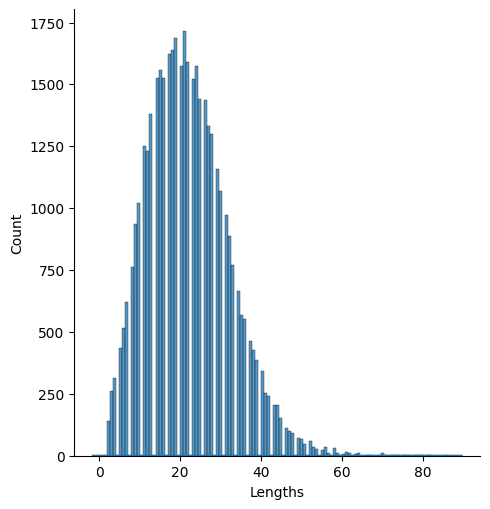

In [19]:
fig_1 = sns.displot(sent_lens_train, x = sent_lens_train)
fig_2 = sns.kdeplot(sent_lens_train)
fig_1.set_axis_labels('Lengths', 'Count')


plt.show()

### Valid sentence's length distribution

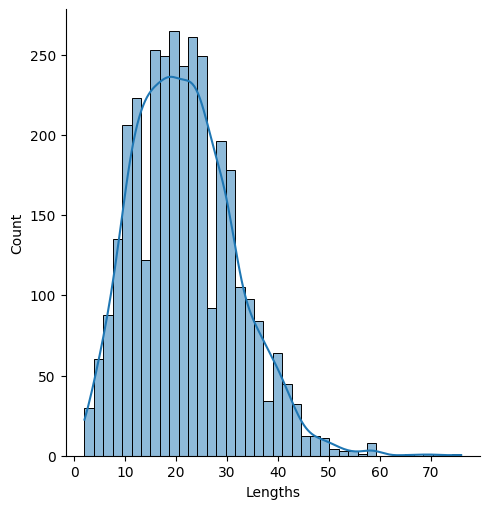

In [20]:
fig_1 = sns.displot(sent_lens_valid, x = sent_lens_valid,  kde = True)
fig_1.set_axis_labels('Lengths', 'Count')


plt.show()

### Test sentence's length distribution

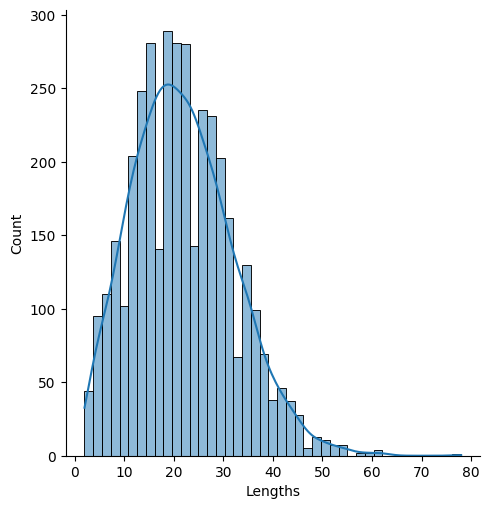

In [21]:
fig_1 = sns.displot(sent_lens_test, x = sent_lens_test,  kde = True)

fig_1.set_axis_labels('Lengths', 'Count')


plt.show()



In these cells the distribution of train is compared coupled with valid and test respectively.

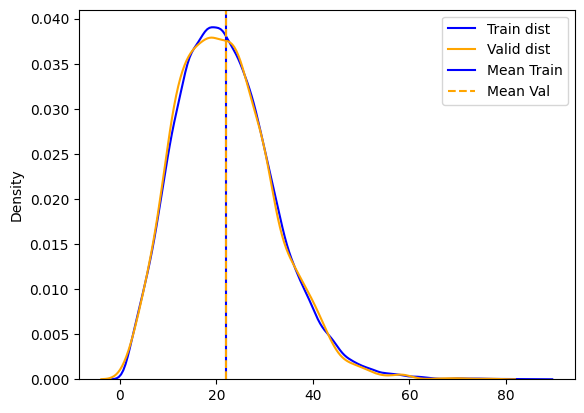

In [22]:
sns.kdeplot(sent_lens_train, label = 'Train dist', color = 'blue')
sns.kdeplot(sent_lens_valid, label = 'Valid dist', color = 'orange')

plt.axvline(avg_sent_len_train, color='blue',  label='Mean Train')
plt.axvline(avg_sent_len_val, color='orange', linestyle='--', label='Mean Val')

plt.legend()


plt.show()



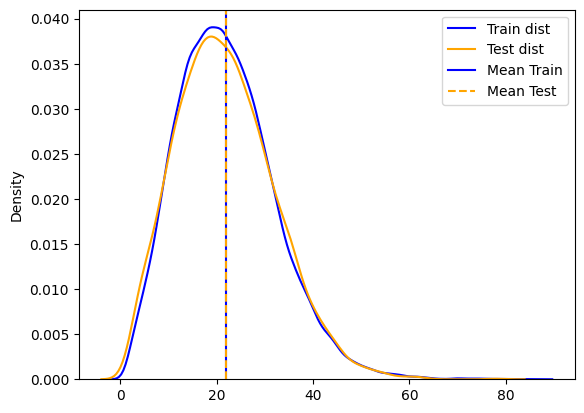

In [23]:
sns.kdeplot(sent_lens_train, label = 'Train dist', color = 'blue')
sns.kdeplot(sent_lens_test, label = 'Test dist', color = 'orange')

plt.axvline(avg_sent_len_train, color='blue',  label='Mean Train')
plt.axvline(avg_sent_len_test, color='orange', linestyle='--', label='Mean Test')

plt.legend()

plt.show()


## OOV words
OOV words are terms that are not part of the train lexicon in a natural language processing environment. We want to investigate if there are unseen terms in both validation and test sets.

In [24]:
def convert(lst):
   res_dict = {}
   for sent in lst:
    for word in sent:
      if(word == '</s>'):
        continue
      if(word not in res_dict.keys()):
        res_dict[word] = 1
      else:
        res_dict[word] += 1
   return res_dict

In [25]:
train_words = convert(tokenized_train)
valid_words = convert(tokenized_valid)
test_words = convert(tokenized_test)

In [26]:
freq_dist_train = Counter(train_words.keys())
freq_dist_val = Counter(valid_words.keys())
freq_dist_test = Counter(test_words.keys())

In [27]:
train_set = set(freq_dist_train)
valid_set = set(freq_dist_val)
test_set = set(freq_dist_test)

In [28]:
oov_train_val = valid_set - train_set.intersection(valid_set)

In [29]:
print(oov_train_val)

set()


In [30]:
oov_train_test = test_set - train_set.intersection(test_set)

In [ ]:
print(oov_train_test)

set()


## Words representation
We go deeper in the analysis of the dataset and plot the top-10 most frequent words along with their representation (meaning % on the corpus) with respect to the total number of words

In [32]:
train_words = sorted(train_words.items(), key=lambda x:x[1], reverse = True)
valid_words = sorted(valid_words.items(), key=lambda x:x[1], reverse = True)
test_words = sorted(test_words.items(), key=lambda x:x[1], reverse = True)

In [33]:
def nbest(d, n=1):
    """
    get n max values from a dict
    :param d: input dict (values are numbers, keys are stings)
    :param n: number of values to get (int)
    :return: dict of top n key-value pairs
    """
    return dict(sorted(d.items(), key=lambda item: item[1], reverse=True)[:n])

In [34]:
def top_freq(freq_dist, n):
    return nbest(dict(freq_dist), n)

In [35]:
top_freq_dist_train = top_freq(train_words, 10)
top_freq_dist_val = top_freq(valid_words, 10)
top_freq_dist_test = top_freq(test_words, 10)


In [36]:
top_freq_dist_train = {key: round(value / sum(sent_lens_train)*100,3) for key, value in top_freq_dist_train.items()}
top_freq_dist_val = {key: round(value / sum(sent_lens_valid)*100,3) for key, value in top_freq_dist_val.items()}
top_freq_dist_test = {key: round(value / sum(sent_lens_test)*100,3) for key, value in top_freq_dist_test.items()}

In [37]:
df = pd.DataFrame.from_dict(top_freq_dist_train, orient='index', columns=['% on corpus'])
df

,% on corpus
the,5.488
unk,4.866
eos,4.547
N,3.511
of,2.637
to,2.555
a,2.301
in,1.946
and,1.889
's,1.058


In [38]:
df = pd.DataFrame.from_dict(top_freq_dist_val, orient='index', columns=['% on corpus'])
df

,% on corpus
the,5.621
unk,4.753
eos,4.596
N,3.550
of,2.498
to,2.387
a,2.372
in,1.898
and,1.897
's,1.184


In [39]:
df = pd.DataFrame.from_dict(top_freq_dist_test, orient='index', columns=['% on corpus'])
df

,% on corpus
unk,5.831
the,5.509
eos,4.574
N,3.069
of,2.670
to,2.484
a,2.218
in,1.995
and,1.872
's,1.098


# Dataset Build

### Vocabulary class
This class is used to convert words to numbers. It takes all the sentences and map each word to the index of the position they are encountered.
As said before it filters out those words that occur rarely (less than the **freq_ts** parameter taken as input).
Through the build_vocab() method it computes the length of the dataset and instatiates three dictionaries:

1.   "index to string" -> itos -> maps the index into the word it represents;
2.   "string to index" -> stoi -> maps the word to its index;
3.  "frequencies" -> computes the number of times a word occur in the dataset.


In [40]:
class Vocabulary:
  def __init__(self, freq_ts):
    self.itos = {0: "pad", 1: "eos", 2: "unk"}
    self.stoi = {"pad": 0, "eos": 1, "unk": 2}
    self.freq_ts = freq_ts
    self.len = 0
    self.frequencies = {}


  def len(self):
    return self.len

  def build_vocab(self, words):
    frequencies = {}
    idx = 3

    for word in words:
        self.len += 1
        if word not in self.frequencies:
          self.frequencies[word] = 1
        else:
          self.frequencies[word] += 1

        if word not in self.stoi:
          if self.frequencies[word] >= self.freq_ts:
            self.itos[idx] = word
            self.stoi[word] = idx
            idx += 1




### PennTreebankDataset class
It is a Dataset object that represents the dataset itself. The (mandatory) methods implemented are:


1.   __init__ : initializes the Vocabulary class
2.   __len__ : returns the len of the dataset in terms of number of sentences
3.  __getitem__ : returns a tuple (inputs, targets, len)



In [41]:
class PennTreebankDataset(Dataset):
  def __init__(self, root_dir, corpus, sentences, transform = None, freq_ts = 3):
    self.root_dir = root_dir
    self.sentences = sentences
    self.transform = transform
    self.freq_ts = freq_ts
    self.frequencies = {}
    self.vocab = Vocabulary(freq_ts)
    self.vocab.build_vocab(corpus)
    self.len = 0


  def __len__(self):
    length = 0
    for sent in self.sentences:
      length += 1

    self.len = length
    return self.len



  def __getitem__(self, index):
      inputs = []
      targets = []
      for i in range(len(self.sentences[index]) - 1):
        inputs.append(self.vocab.stoi[self.sentences[index][i]] if self.sentences[index][i] in self.vocab.stoi.keys() else 2)
        targets.append(self.vocab.stoi[self.sentences[index][i+1]] if self.sentences[index][i+1] in self.vocab.stoi.keys() else 2)

      return inputs, targets, len(self.sentences[index]) - 1

  def freq(self, sentences):
    for sent in sentences:
      for word in sent:
        if(word not in self.frequencies.keys()):
          self.frequencies[word] = 1
        else:
          self.frequencies[word] += 1


We create the list penn_tree_bank to pass as input to the PennTreebankDataset class to ensure that the vocabularies of the three dataloaders are built equally.

In [42]:
penn_tree_bank = [word for sent in preprocessed_corpus_train for word in sent]

### Train Dataset

In [43]:
train_dataset = PennTreebankDataset('/content/gdrive/MyDrive/ptbdataset', penn_tree_bank, preprocessed_corpus_train)

### Validation (Development) Dataset

In [44]:
valid_dataset = PennTreebankDataset('/content/gdrive/MyDrive/ptbdataset', penn_tree_bank, preprocessed_corpus_valid)

### Test Dataset

In [45]:
test_dataset = PennTreebankDataset('/content/gdrive/MyDrive/ptbdataset', penn_tree_bank, preprocessed_corpus_test)

## Custom collate function
The collate function makes sure that the batches of samples are equal sized and for that reason it:

1.   Loads samples and their labels;
2.   Pads sentences to make them of the same length within the a batch.
The pad token is the **</s>** token



In [46]:
def collate_fn(batch):
  def merge(sequences):
    '''
    merge from batch * sent_len to batch * max_len
    '''

    lengths = [len(seq) for seq in sequences]

    max_len = 1 if max(lengths)==0 else max(lengths)

    padded_seqs = torch.LongTensor(len(sequences),max_len).fill_(0)

    for i, seq in enumerate(sequences):

      end = lengths[i]
      padded_seqs[i, :end] = torch.Tensor(seq)


    padded_seqs = padded_seqs.detach()
    return padded_seqs, lengths

  batch.sort(key=lambda x: len(x[0]), reverse=True)

  new_item = []
  inputs = []
  targets = []

  for item in batch:
    inputs.append(item[0])
    targets.append(item[1])

  input, lens = merge(inputs)
  targets, _ = merge(targets)

  return input, targets, lens



## Constant values

In [47]:
batch_size = 32
N_EPOCHS = 50
PAD_TOKEN = 0
EOS_TOKEN = 'eos'
clip = 0.25
patience = 5

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
criterion = nn.CrossEntropyLoss(ignore_index = PAD_TOKEN)


## Train dataloader

In [48]:
train_dataloader = DataLoader(train_dataset, batch_size, collate_fn = collate_fn, shuffle = True)

## Validation dataloader

In [49]:
valid_dataloader = DataLoader(valid_dataset, batch_size, collate_fn = collate_fn)

## Test dataloader

In [50]:
test_dataloader = DataLoader(test_dataset, batch_size, collate_fn = collate_fn)

# Utils

### Weights initialization
This weights initialization function is taken from ***Laboratory-10-SequenceNN*** of Natural Language Understanding course. It might help the network to initialize from a good starting point and favour convergence.

In [51]:
def init_weights(mat):
    for m in mat.modules():
        if type(m) in [nn.GRU, nn.LSTM, nn.RNN]:
            for name, param in m.named_parameters():
                if 'weight_ih' in name:
                    for idx in range(4):
                        mul = param.shape[0]//4
                        torch.nn.init.xavier_uniform_(param[idx*mul:(idx+1)*mul])
                elif 'weight_hh' in name:
                    for idx in range(4):
                        mul = param.shape[0]//4
                        torch.nn.init.orthogonal_(param[idx*mul:(idx+1)*mul])
                elif 'bias' in name:
                    param.data.fill_(0)
        else:
            if type(m) in [nn.Linear]:
                torch.nn.init.uniform_(m.weight, -0.01, 0.01)
                if m.bias != None:
                    m.bias.data.fill_(0.01)

### Train loop - Eval loop - Test loop

In [52]:
def train_loop(model, data, optimizer, criterion, batch_size, clip, device):
  model.train()
  epoch_loss = 0.0
  hidden = model.init_hidden(batch_size, device)
  for x, y in (enumerate(data)):
      optimizer.zero_grad() # Zeroing the gradient
      hidden = model.detach_hidden(hidden)

      src = y[0].to(device)
      target = y[1].to(device)
      lengths = torch.Tensor(y[2])

      output, hidden = model(src, hidden, lengths)

      loss = criterion(output, target.view(-1))

      loss.backward()
      torch.nn.utils.clip_grad_norm_(model.parameters(), clip)
      optimizer.step() # Update the weights
      epoch_loss += loss.item()

  return epoch_loss / (x + 1)

In [53]:
def eval_loop(model, data, optimizer, criterion, batch_size, device):
  model.eval()
  epoch_loss = 0.0

  hidden = model.init_hidden(batch_size, device)

  with torch.no_grad():
     for x, y in (enumerate(data)):
      optimizer.zero_grad() # Zeroing the gradient
      hidden = model.detach_hidden(hidden)

      src = y[0].to(device)
      target = y[1].to(device)
      lengths = torch.Tensor(y[2])
      output, hidden = model(src, hidden, lengths)
      loss = criterion(output, target.view(-1))
      epoch_loss += loss.item()

  return epoch_loss / (x + 1)


In [54]:
def test_loop(model, data, optimizer, criterion, batch_size, device):
  model.eval()
  epoch_loss = 0.0
  hidden = model.init_hidden(batch_size, device)
  with torch.no_grad():
     for x, y in (enumerate(data)):
      optimizer.zero_grad() # Zeroing the gradient
      hidden = model.detach_hidden(hidden)
      src = y[0].to(device)
      target = y[1].to(device)
      lengths = torch.Tensor(y[2])

      output, hidden = model(src, hidden, lengths)

      loss = criterion(output, target.view(-1))

      epoch_loss += loss.item()

  return epoch_loss / (x + 1)


## Generate sentence function for inference tasks

I implemented a function to generate a sentence given one or more words. This function provides a **subjective metric** to evaluate the performance of the LSTM models and see if better Perplexity scores reflect more meaningful generated sentences.

**Note**: the 'unk' token cannot be output. This choice comes from the fact that the 'unk' word represents almost 5% of the total words in the 3 splits and this might bias the results.

In [55]:
def generate_sentence(model, s, vocab, max_len=25, topk=1, unk=False, device='cuda:0'):
    s = s.lower()
    sent = s.split(' ')
    out_word = 'unk'

    hidden = model.init_hidden(1, device)

    # take the 2 most probable words to have a replacement for unk
    if (not unk) and topk == 1:
        topk = 2

    while out_word != 'eos' and len(sent) < max_len:
        input = [train_dataset.vocab.stoi[w] for w in sent]

        length = torch.tensor([len(input)])

        input = torch.tensor(input)
        input = torch.unsqueeze(input, 0)
        input = input.to(device)

        out, hidden = model(input, hidden, length)
        out = out.reshape(-1, vocab_size)

        out = torch.topk(out, topk, dim=-1).indices

        out = out[-1]
        if len(out) > 1:
            out = torch.squeeze(out, 0)


        out_w = random.choice(out)

        if not unk:
            while train_dataset.vocab.itos[out_w.item()] == 'unk':
                out_w = random.choice(out)


        out_word = train_dataset.vocab.itos[out_w.item()]
        sent.append(out_word)

    return sent

# Model: (Vanilla) Long-Short-Term-Memory
Long Short Term Memory (LSTM) is an artificial neural network with recurrent connections and LSTM units. An LSTM unit is composed of a cell with an input gate, an output gate and a forget gate.


1.  The **cell** remembers values over arbitrary time intervals and the three gates regulate the flow of information into and out of the cell;
2.   **Forget gates** decide what information to discard from a previous state;
3.   **Input gates** decide which pieces of new information to store in the current state, using the same system as forget gates;
4.  **Output gates** control which pieces of information in the current state to output by assigning a value from 0 to 1 to the information, considering the previous and current states.


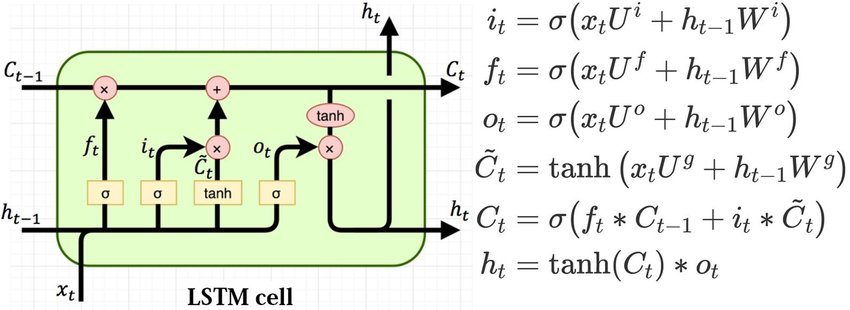

LSTM Class for implementing the Long-Short-Term-Memory network

In [56]:
class LSTM(nn.Module):
    def __init__(self, vocab_size, embedding_dim, hidden_dim, num_layers, pad_idx,
                 device):

        super().__init__()
        self.num_layers = num_layers
        self.hidden_dim = hidden_dim
        self.embedding_dim = embedding_dim
        self.pad_value = pad_idx

        self.embedding = nn.Embedding(vocab_size, embedding_dim, padding_idx=pad_idx)
        self.lstm = nn.LSTM(embedding_dim, hidden_dim, num_layers=num_layers,
                    batch_first=True)

        self.fc = nn.Linear(hidden_dim, vocab_size)


    def forward(self, src, hidden, lengths):

        embedding = self.embedding(src)
        packed_input = pack_padded_sequence(embedding, lengths, batch_first = True)
        output, hidden = self.lstm(packed_input)
        utt_encoded, input_sizes = pad_packed_sequence(output, batch_first=True, padding_value=self.pad_value)
        prediction = self.fc(utt_encoded)
        prediction = prediction.reshape(prediction.size(0)*prediction.size(1), prediction.size(2))
        return prediction, hidden

    def init_weights(self):
        init_range_emb = 0.1
        init_range_other = 1/math.sqrt(self.hidden_dim)
        self.embedding.weight.data.uniform_(-init_range_emb, init_range_emb)
        self.fc.weight.data.uniform_(-init_range_other, init_range_other)
        self.fc.bias.data.zero_()

        for i in range(self.num_layers):
            self.lstm.all_weights[i][0] = torch.FloatTensor(self.embedding_dim,
                    self.hidden_dim).uniform_(-init_range_other, init_range_other)
            self.lstm.all_weights[i][1] = torch.FloatTensor(self.hidden_dim,
                    self.hidden_dim).uniform_(-init_range_other, init_range_other)

    def init_hidden(self, batch_size, device):
        hidden = torch.zeros(self.num_layers, batch_size, self.hidden_dim).to(device)
        cell = torch.zeros(self.num_layers,  batch_size, self.hidden_dim).to(device)

        return hidden, cell

    def detach_hidden(self, hidden):
        hidden, cell = hidden
        hidden = hidden.detach()
        cell = cell.detach()

        return hidden, cell



## Model architecture and hyperparameters
In order to define a baseline I implemented a "Vanilla" LSTM as follow:

1.  one LSTM layer (num_layers parameter);
2.  embedding dimension equal to 300 units;
3.  hidden dimension equal to 200 units.

As written in [Merity et al.](https://arxiv.org/abs/1708.02182) the SGD seems to be the best optimizer for RNN and LSTM.
After some runs I decided, basing on the results obtained, to set the final hyperparameters in this way:

1.   batch size equal to 32
2.   learning rate equal to 1.0


In [57]:
vocab_size = len(train_dataset.vocab.itos)
embedding_dim = 300
hidden_dim = 200
num_layers = 1
dropout_rate = 0.2
lr = 1.0

In [58]:
lstm = LSTM(vocab_size, embedding_dim, hidden_dim, num_layers, PAD_TOKEN, device).to(device)
lstm.apply(init_weights)
num_params = sum(p.numel() for p in lstm.parameters() if p.requires_grad)
print(f'The model has {num_params:,} trainable parameters')

optimizer = optim.SGD(lstm.parameters(), lr=lr)


The model has 5,387,051 trainable parameters


## Main

In [59]:
train_losses_lstm = []
valid_losses_lstm = []
test_losses_lstm = []
ppl_score_lstm_val = []
ppl_score_lstm_test = []
sampled_epoch_lstm = []

best_valid_loss = float('inf')
lr_scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, factor=0.1, patience=0)

for epoch in tqdm(range(N_EPOCHS)):
  print('\nEpoch', epoch)
  train_loss = train_loop(lstm, train_dataloader, optimizer, criterion, batch_size, clip, device)
  eval_loss = eval_loop(lstm, valid_dataloader, optimizer, criterion, batch_size, device)
  test_loss = test_loop(lstm, test_dataloader, optimizer, criterion, batch_size, device)
  print(f'\n\tTrain Loss: {train_loss:.3f}')
  print(f'\tValid Loss: {eval_loss:.3f}')
  print(f'\tTest Loss: {test_loss:.3f}')
  print(f'\tTrain Perplexity: {math.exp(train_loss):.3f}')
  print(f'\tValid Perplexity: {math.exp(eval_loss):.3f}')
  print(f'\tTest Perplexity: {math.exp(test_loss):.3f}')
  lr_scheduler.step(eval_loss)

  if eval_loss < best_valid_loss:
    best_valid_loss = eval_loss
    torch.save(lstm.state_dict(), '/content/gdrive/MyDrive/best-val-lstm_lm.pt')
  else:
    patience -= 1
    if patience <= 0: # Early stopping with patience
      break

  train_losses_lstm.append(train_loss)
  valid_losses_lstm.append(eval_loss)
  test_losses_lstm.append(test_loss)
  ppl_score_lstm_val.append(math.exp(eval_loss))
  ppl_score_lstm_test.append(math.exp(test_loss))
  sampled_epoch_lstm.append(epoch)

  0%|          | 0/50 [00:00<?, ?it/s]


Epoch 0

	Train Loss: 6.323
	Valid Loss: 5.896
	Test Loss: 5.902
	Train Perplexity: 557.153
	Valid Perplexity: 363.715
	Test Perplexity: 365.783


  2%|▏         | 1/50 [00:20<16:35, 20.32s/it]


Epoch 1


  4%|▍         | 2/50 [00:38<15:13, 19.03s/it]


	Train Loss: 5.809
	Valid Loss: 5.662
	Test Loss: 5.666
	Train Perplexity: 333.286
	Valid Perplexity: 287.718
	Test Perplexity: 288.911

Epoch 2


  6%|▌         | 3/50 [00:57<14:46, 18.87s/it]


	Train Loss: 5.610
	Valid Loss: 5.531
	Test Loss: 5.533
	Train Perplexity: 273.142
	Valid Perplexity: 252.371
	Test Perplexity: 252.939

Epoch 3


  8%|▊         | 4/50 [01:15<14:22, 18.75s/it]


	Train Loss: 5.475
	Valid Loss: 5.439
	Test Loss: 5.438
	Train Perplexity: 238.552
	Valid Perplexity: 230.277
	Test Perplexity: 230.079

Epoch 4


 10%|█         | 5/50 [01:35<14:19, 19.09s/it]


	Train Loss: 5.371
	Valid Loss: 5.377
	Test Loss: 5.373
	Train Perplexity: 215.182
	Valid Perplexity: 216.404
	Test Perplexity: 215.519

Epoch 5


 12%|█▏        | 6/50 [01:54<13:54, 18.96s/it]


	Train Loss: 5.288
	Valid Loss: 5.323
	Test Loss: 5.319
	Train Perplexity: 198.014
	Valid Perplexity: 205.086
	Test Perplexity: 204.155

Epoch 6


 14%|█▍        | 7/50 [02:13<13:36, 18.99s/it]


	Train Loss: 5.217
	Valid Loss: 5.277
	Test Loss: 5.269
	Train Perplexity: 184.296
	Valid Perplexity: 195.774
	Test Perplexity: 194.136

Epoch 7


 16%|█▌        | 8/50 [02:31<13:15, 18.94s/it]


	Train Loss: 5.156
	Valid Loss: 5.248
	Test Loss: 5.237
	Train Perplexity: 173.443
	Valid Perplexity: 190.186
	Test Perplexity: 188.156

Epoch 8


 18%|█▊        | 9/50 [02:50<12:50, 18.80s/it]


	Train Loss: 5.101
	Valid Loss: 5.213
	Test Loss: 5.203
	Train Perplexity: 164.252
	Valid Perplexity: 183.661
	Test Perplexity: 181.804

Epoch 9


 20%|██        | 10/50 [03:09<12:32, 18.82s/it]


	Train Loss: 5.052
	Valid Loss: 5.187
	Test Loss: 5.173
	Train Perplexity: 156.329
	Valid Perplexity: 179.006
	Test Perplexity: 176.517

Epoch 10


 22%|██▏       | 11/50 [03:28<12:13, 18.81s/it]


	Train Loss: 5.008
	Valid Loss: 5.164
	Test Loss: 5.152
	Train Perplexity: 149.552
	Valid Perplexity: 174.930
	Test Perplexity: 172.813

Epoch 11


 24%|██▍       | 12/50 [03:46<11:50, 18.70s/it]


	Train Loss: 4.967
	Valid Loss: 5.146
	Test Loss: 5.134
	Train Perplexity: 143.578
	Valid Perplexity: 171.787
	Test Perplexity: 169.774

Epoch 12


 26%|██▌       | 13/50 [04:05<11:36, 18.84s/it]


	Train Loss: 4.930
	Valid Loss: 5.130
	Test Loss: 5.117
	Train Perplexity: 138.390
	Valid Perplexity: 168.939
	Test Perplexity: 166.813

Epoch 13


 28%|██▊       | 14/50 [04:24<11:15, 18.75s/it]


	Train Loss: 4.895
	Valid Loss: 5.111
	Test Loss: 5.099
	Train Perplexity: 133.643
	Valid Perplexity: 165.865
	Test Perplexity: 163.869

Epoch 14


 30%|███       | 15/50 [04:42<10:53, 18.66s/it]


	Train Loss: 4.862
	Valid Loss: 5.100
	Test Loss: 5.085
	Train Perplexity: 129.312
	Valid Perplexity: 164.004
	Test Perplexity: 161.581

Epoch 15


 32%|███▏      | 16/50 [05:01<10:37, 18.74s/it]


	Train Loss: 4.833
	Valid Loss: 5.083
	Test Loss: 5.071
	Train Perplexity: 125.544
	Valid Perplexity: 161.198
	Test Perplexity: 159.255

Epoch 16


 34%|███▍      | 17/50 [05:20<10:16, 18.70s/it]


	Train Loss: 4.805
	Valid Loss: 5.076
	Test Loss: 5.063
	Train Perplexity: 122.074
	Valid Perplexity: 160.131
	Test Perplexity: 158.053

Epoch 17


 36%|███▌      | 18/50 [05:39<09:59, 18.73s/it]


	Train Loss: 4.777
	Valid Loss: 5.067
	Test Loss: 5.053
	Train Perplexity: 118.760
	Valid Perplexity: 158.774
	Test Perplexity: 156.496

Epoch 18


 38%|███▊      | 19/50 [05:57<09:40, 18.72s/it]


	Train Loss: 4.750
	Valid Loss: 5.057
	Test Loss: 5.046
	Train Perplexity: 115.585
	Valid Perplexity: 157.063
	Test Perplexity: 155.425

Epoch 19


 40%|████      | 20/50 [06:16<09:20, 18.70s/it]


	Train Loss: 4.725
	Valid Loss: 5.050
	Test Loss: 5.035
	Train Perplexity: 112.749
	Valid Perplexity: 155.945
	Test Perplexity: 153.649

Epoch 20


 42%|████▏     | 21/50 [06:35<09:06, 18.84s/it]


	Train Loss: 4.702
	Valid Loss: 5.042
	Test Loss: 5.027
	Train Perplexity: 110.188
	Valid Perplexity: 154.759
	Test Perplexity: 152.410

Epoch 21


 44%|████▍     | 22/50 [06:54<08:44, 18.73s/it]


	Train Loss: 4.678
	Valid Loss: 5.036
	Test Loss: 5.020
	Train Perplexity: 107.603
	Valid Perplexity: 153.792
	Test Perplexity: 151.358

Epoch 22


 46%|████▌     | 23/50 [07:12<08:24, 18.67s/it]


	Train Loss: 4.657
	Valid Loss: 5.031
	Test Loss: 5.012
	Train Perplexity: 105.352
	Valid Perplexity: 153.049
	Test Perplexity: 150.207

Epoch 23


 48%|████▊     | 24/50 [07:31<08:07, 18.76s/it]


	Train Loss: 4.636
	Valid Loss: 5.027
	Test Loss: 5.011
	Train Perplexity: 103.124
	Valid Perplexity: 152.527
	Test Perplexity: 150.036

Epoch 24


 50%|█████     | 25/50 [07:50<07:46, 18.68s/it]


	Train Loss: 4.615
	Valid Loss: 5.024
	Test Loss: 5.006
	Train Perplexity: 100.997
	Valid Perplexity: 152.057
	Test Perplexity: 149.322

Epoch 25


 52%|█████▏    | 26/50 [08:09<07:30, 18.77s/it]


	Train Loss: 4.595
	Valid Loss: 5.018
	Test Loss: 5.006
	Train Perplexity: 98.999
	Valid Perplexity: 151.161
	Test Perplexity: 149.330

Epoch 26


 54%|█████▍    | 27/50 [08:27<07:10, 18.73s/it]


	Train Loss: 4.576
	Valid Loss: 5.013
	Test Loss: 4.997
	Train Perplexity: 97.102
	Valid Perplexity: 150.292
	Test Perplexity: 148.027

Epoch 27


 56%|█████▌    | 28/50 [08:46<06:50, 18.64s/it]


	Train Loss: 4.558
	Valid Loss: 5.010
	Test Loss: 4.996
	Train Perplexity: 95.417
	Valid Perplexity: 149.898
	Test Perplexity: 147.873

Epoch 28


 58%|█████▊    | 29/50 [09:05<06:34, 18.80s/it]


	Train Loss: 4.539
	Valid Loss: 5.008
	Test Loss: 4.990
	Train Perplexity: 93.621
	Valid Perplexity: 149.588
	Test Perplexity: 146.999

Epoch 29


 60%|██████    | 30/50 [09:23<06:14, 18.71s/it]


	Train Loss: 4.522
	Valid Loss: 5.006
	Test Loss: 4.990
	Train Perplexity: 92.007
	Valid Perplexity: 149.246
	Test Perplexity: 146.905

Epoch 30


 62%|██████▏   | 31/50 [09:42<05:53, 18.61s/it]


	Train Loss: 4.505
	Valid Loss: 5.007
	Test Loss: 4.990
	Train Perplexity: 90.497
	Valid Perplexity: 149.475
	Test Perplexity: 146.863

Epoch 31


 64%|██████▍   | 32/50 [10:00<05:35, 18.66s/it]


	Train Loss: 4.450
	Valid Loss: 4.996
	Test Loss: 4.980
	Train Perplexity: 85.606
	Valid Perplexity: 147.823
	Test Perplexity: 145.494

Epoch 32


 66%|██████▌   | 33/50 [10:19<05:16, 18.61s/it]


	Train Loss: 4.444
	Valid Loss: 4.996
	Test Loss: 4.981
	Train Perplexity: 85.136
	Valid Perplexity: 147.856
	Test Perplexity: 145.561

Epoch 33


 68%|██████▊   | 34/50 [10:38<04:58, 18.68s/it]


	Train Loss: 4.437
	Valid Loss: 4.996
	Test Loss: 4.980
	Train Perplexity: 84.486
	Valid Perplexity: 147.814
	Test Perplexity: 145.532

Epoch 34


 70%|███████   | 35/50 [10:56<04:40, 18.67s/it]


	Train Loss: 4.435
	Valid Loss: 4.996
	Test Loss: 4.980
	Train Perplexity: 84.350
	Valid Perplexity: 147.810
	Test Perplexity: 145.531

Epoch 35


 72%|███████▏  | 36/50 [11:15<04:20, 18.63s/it]


	Train Loss: 4.435
	Valid Loss: 4.996
	Test Loss: 4.980
	Train Perplexity: 84.337
	Valid Perplexity: 147.809
	Test Perplexity: 145.531

Epoch 36


 74%|███████▍  | 37/50 [11:34<04:03, 18.74s/it]


	Train Loss: 4.435
	Valid Loss: 4.996
	Test Loss: 4.980
	Train Perplexity: 84.338
	Valid Perplexity: 147.809
	Test Perplexity: 145.531

Epoch 37


 76%|███████▌  | 38/50 [11:52<03:43, 18.65s/it]


	Train Loss: 4.434
	Valid Loss: 4.996
	Test Loss: 4.980
	Train Perplexity: 84.300
	Valid Perplexity: 147.809
	Test Perplexity: 145.531

Epoch 38


 78%|███████▊  | 39/50 [12:11<03:25, 18.66s/it]


	Train Loss: 4.435
	Valid Loss: 4.996
	Test Loss: 4.980
	Train Perplexity: 84.379
	Valid Perplexity: 147.809
	Test Perplexity: 145.531

Epoch 39


 80%|████████  | 40/50 [12:30<03:06, 18.68s/it]


	Train Loss: 4.435
	Valid Loss: 4.996
	Test Loss: 4.980
	Train Perplexity: 84.343
	Valid Perplexity: 147.809
	Test Perplexity: 145.531

Epoch 40


 82%|████████▏ | 41/50 [12:48<02:47, 18.57s/it]


	Train Loss: 4.435
	Valid Loss: 4.996
	Test Loss: 4.980
	Train Perplexity: 84.365
	Valid Perplexity: 147.809
	Test Perplexity: 145.531

Epoch 41


 82%|████████▏ | 41/50 [13:07<02:52, 19.21s/it]


	Train Loss: 4.435
	Valid Loss: 4.996
	Test Loss: 4.980
	Train Perplexity: 84.315
	Valid Perplexity: 147.809
	Test Perplexity: 145.531


## Plots
Plots of the train, validation and test losses during epochs.

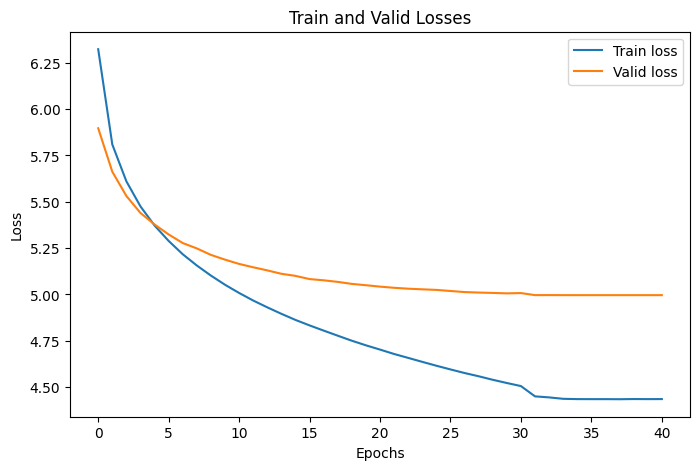

In [106]:
plt.figure(num = 3, figsize=(8, 5)).patch.set_facecolor('white')
plt.title('Train and Valid Losses')
plt.ylabel('Loss')
plt.xlabel('Epochs')
plt.plot(sampled_epoch_lstm, train_losses_lstm, label='Train loss')
plt.plot(sampled_epoch_lstm, valid_losses_lstm, label='Valid loss')
plt.legend()
plt.savefig('valid_loss_curve_lstm.png')
plt.show()

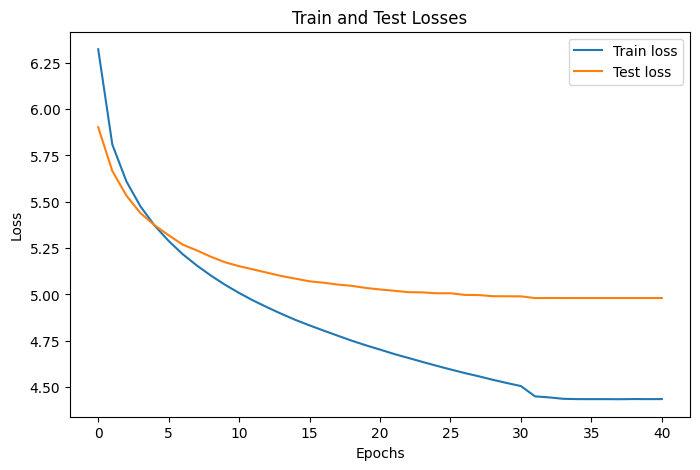

In [61]:
plt.figure(num = 3, figsize=(8, 5)).patch.set_facecolor('white')
plt.title('Train and Test Losses')
plt.ylabel('Loss')
plt.xlabel('Epochs')
plt.plot(sampled_epoch_lstm, train_losses_lstm, label='Train loss')
plt.plot(sampled_epoch_lstm, test_losses_lstm, label='Test loss')
plt.legend()
plt.savefig('test_loss_curve_lstm.png')
plt.show()

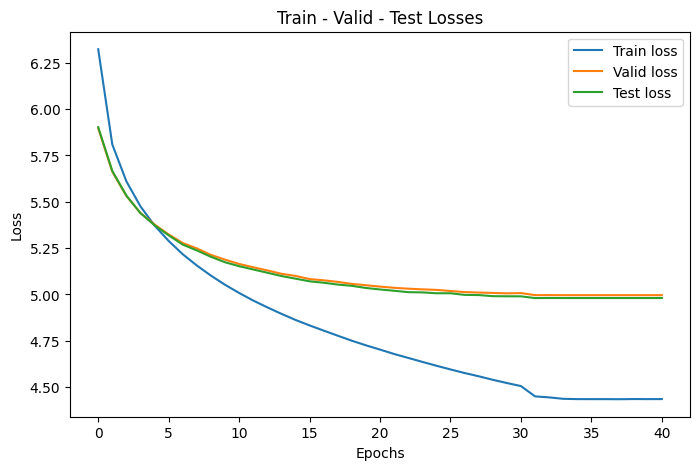

In [62]:
plt.figure(num = 3, figsize=(8, 5)).patch.set_facecolor('white')
plt.title('Train - Valid - Test Losses')
plt.ylabel('Loss')
plt.xlabel('Epochs')
plt.plot(sampled_epoch_lstm, train_losses_lstm, label='Train loss')
plt.plot(sampled_epoch_lstm, valid_losses_lstm, label='Valid loss')
plt.plot(sampled_epoch_lstm, test_losses_lstm, label='Test loss')
plt.legend()
plt.savefig('valid_test_loss_curve_lstm.png')
plt.show()

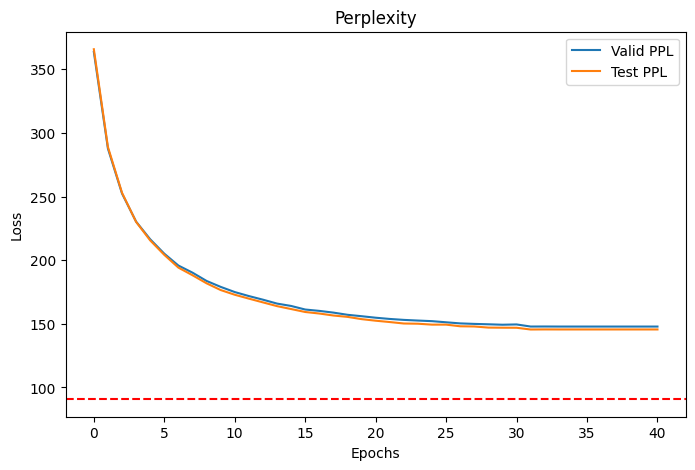

In [63]:
plt.figure(num = 3, figsize=(8, 5)).patch.set_facecolor('white')
plt.title('Perplexity')
plt.ylabel('PPL')
plt.xlabel('Epochs')
plt.plot(sampled_epoch_lstm, ppl_score_lstm_val, label='Valid PPL')
plt.plot(sampled_epoch_lstm, ppl_score_lstm_test, label='Test PPL')
plt.axhline(y=90.7, color='r', linestyle='--')
plt.legend()
plt.savefig('lstm_ppl.png')
plt.show()

## Sentence generation
Each of the models in this project is tested by asking to generate a sentence starting from one or more words. Obviusly, to comparate better the models the input words are the same for each model

In [64]:
lstm.load_state_dict(torch.load('/content/gdrive/MyDrive/best-val-lstm_lm.pt'))

<All keys matched successfully>

In [65]:
print(' '.join(generate_sentence(lstm, 'the', train_dataset.vocab)))

the company said the company is expected for sale in the company 's N million shares eos


In [66]:
print(' '.join(generate_sentence(lstm, 'a', train_dataset.vocab)))

a spokesman for the company said it expects the company 's net to N billion yen N million in the first quarter eos


In [ ]:
print(' '.join(generate_sentence(lstm, 'new york', train_dataset.vocab)))

new york stock exchange volume totaled shares up N cents to close at N eos


In [ ]:
print(' '.join(generate_sentence(lstm, 'he said many of the countries', train_dataset.vocab)))

he said many of the countries would have been able for a N N increase in the third quarter eos


## Conclusions
As we can see the model shows a tendency to overfit. The training stops after around 40 epochs for the effect of early-stopping and it is very far from the baseline of 90.7 PPL. The plots reveal that the LSTM behaves equally between the validation and test sets, indeed the two curves are quite overlapped. The need of a regularization technique such as Dropout seems to be crucial for outperforming the baseline.

# "Fixed window" LSTM

This method is proposed by Essam Wisam in ["Language Modeling with LSTMs in PyTorch"](https://towardsdatascience.com/language-modeling-with-lstms-in-pytorch-381a26badcbf). He shows an alternative method to load batches without the use of a custom collate function and a DataLoader class.

## Custom function to load batches.
This function represents an alternative method to load batches and train the model.
Here we define get_data() function that does 4 things:
1.  It appends each sequence of tokenized text with an <eos> token to mark its end. (line 5);
2.  It encodes each token to a numerical value equal to its index in the vocabulary. Note that those that occurred less than thrice in the dataset will map to the unknown token (line 6);
3.  It combines all the numerical sequences into a list (1D Tensor) (line 2, line 8);
4.  It reshapes it into a 2D tensor of dimensions [batch_size, num_batches] (line 10, line 11).


In [ ]:
length_train = train_dataset.__len__()
length_valid = valid_dataset.__len__()
length_test = test_dataset.__len__()

In [ ]:
batch_size = 128

def get_data(dataset, length, batch_size):
  data = []

  num_batches = (length // batch_size)

  for x,y in enumerate(dataset):
    for i in range(len(y[0])):
      data.append(y[0][i])


  data = torch.LongTensor(data)

  data = data[:num_batches * batch_size]

  data = data.view(batch_size, num_batches)
  print(data.shape)
  return data

In [ ]:
train_data = get_data(train_dataset, length_train, batch_size)
valid_data = get_data(valid_dataset, length_valid, batch_size)
test_data = get_data(test_dataset, length_test, batch_size)

torch.Size([128, 328])
torch.Size([128, 26])
torch.Size([128, 29])


In [ ]:
def get_batch(data, seq_len, idx):
  src = data[:, idx:idx+seq_len]
  target = data[:, idx+1:idx+seq_len+1]

  return src, target

In [ ]:
class LSTM_FW(nn.Module):
    def __init__(self, vocab_size, embedding_dim, hidden_dim, num_layers, dropout_rate,
                tie_weights, device):

        super().__init__()
        self.num_layers = num_layers
        self.hidden_dim = hidden_dim
        self.embedding_dim = embedding_dim

        self.embedding = nn.Embedding(vocab_size, embedding_dim)
        self.lstm = nn.LSTM(embedding_dim, hidden_dim, num_layers=num_layers,
                    dropout=dropout_rate, batch_first=True)

        self.fc = nn.Linear(hidden_dim, vocab_size)
        self.init_weights()
        if tie_weights:
            assert embedding_dim == hidden_dim, 'cannot tie, check dims'
            self.embedding.weight = self.fc.weight
        '''
        if dropout_rate:
            self.lstm = WeightDrop(self.lstm, ['weight_hh_l0','weight_hh_l1'], dropout=dropout_rate)
        '''
    def embedding_dropout(self, embed, words, p=0.1):
        """
        Taken from original authors code.
        TODO: re-write and add test
        """
        if not self.training:
            masked_embed_weight = embed.weight
        elif not p:
            masked_embed_weight = embed.weight
        else:
            mask = embed.weight.data.new().resize_((embed.weight.size(0), 1)).bernoulli_(1 - p).expand_as(embed.weight) / (1 - p)
            masked_embed_weight = mask * embed.weight

        padding_idx = embed.padding_idx
        if padding_idx is None:
            padding_idx = -1

        X = F.embedding(words, masked_embed_weight,
                        padding_idx, embed.max_norm, embed.norm_type,
                        embed.scale_grad_by_freq, embed.sparse)
        return X

    def forward(self, src, hidden):

        embedding = self.embedding(src)
        prediction, hidden = self.lstm(embedding, hidden)


        prediction = self.fc(prediction)

        return prediction, hidden

    def init_weights(self):
        init_range_emb = 0.1
        init_range_other = 1/math.sqrt(self.hidden_dim)
        self.embedding.weight.data.uniform_(-init_range_emb, init_range_emb)
        self.fc.weight.data.uniform_(-init_range_other, init_range_other)
        self.fc.bias.data.zero_()

        for i in range(self.num_layers):
            self.lstm.all_weights[i][0] = torch.FloatTensor(self.embedding_dim,
                    self.hidden_dim).uniform_(-init_range_other, init_range_other)
            self.lstm.all_weights[i][1] = torch.FloatTensor(self.hidden_dim,
                    self.hidden_dim).uniform_(-init_range_other, init_range_other)

    def init_hidden(self, batch_size, device):
        hidden = torch.zeros(self.num_layers, batch_size, self.hidden_dim).to(device)
        #hidden = torch.zeros(self.num_layers, self.hidden_dim).to(device)
        cell = torch.zeros(self.num_layers,  batch_size, self.hidden_dim).to(device)
        #cell = torch.zeros(self.num_layers, self.hidden_dim).to(device)

        return hidden, cell

    def detach_hidden(self, hidden):
        hidden, cell = hidden
        hidden = hidden.detach()
        cell = cell.detach()

        return hidden, cell

## Train loop - Eval loop - Test loop

In [ ]:
def train_lstm(model, data, optimizer, criterion, batch_size, seq_len, clip, device):

    epoch_loss = 0
    model.train()
    # drop all batches that are not a multiple of seq_len
    num_batches = data.shape[-1]
    data = data[:, :num_batches - (num_batches -1) % seq_len].to(device)
    num_batches = data.shape[-1]

    hidden = model.init_hidden(batch_size, device)

    for idx in tqdm(range(0, num_batches - 1, seq_len), desc='Training: ',leave=False):  # The last batch can't be a src
        optimizer.zero_grad()
        hidden = model.detach_hidden(hidden)
        src, target = get_batch(data, seq_len, idx)

        src, target = src.to(device), target.to(device)
        batch_size = src.shape[0]
        prediction, hidden = model(src, hidden)
        prediction = prediction.reshape(batch_size * seq_len, -1)

        target = target.reshape(-1)


        loss = criterion(prediction, target)

        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), clip)
        optimizer.step()
        epoch_loss += loss.item() * seq_len

    return epoch_loss / num_batches

In [ ]:
def evaluate_lstm(model, data, criterion, batch_size, seq_len, device):

    epoch_loss = 0
    model.eval()
    num_batches = data.shape[-1]
    data = data[:, :num_batches - (num_batches -1) % seq_len]
    num_batches = data.shape[-1]

    hidden = model.init_hidden(batch_size, device)

    with torch.no_grad():
        for idx in range(0, num_batches - 1, seq_len):
            hidden = model.detach_hidden(hidden)
            src, target = get_batch(data, seq_len, idx)
            src, target = src.to(device), target.to(device)
            batch_size= src.shape[0]

            prediction, hidden = model(src, hidden)
            prediction = prediction.reshape(batch_size * seq_len, -1)
            target = target.reshape(-1)

            loss = criterion(prediction, target)
            epoch_loss += loss.item() * seq_len

    return epoch_loss / num_batches

In [ ]:
def test_lstm(model, data, criterion, batch_size, seq_len, device):

    epoch_loss = 0
    model.eval()
    num_batches = data.shape[-1]
    data = data[:, :num_batches - (num_batches -1) % seq_len]
    num_batches = data.shape[-1]

    hidden = model.init_hidden(batch_size, device)

    with torch.no_grad():
        for idx in range(0, num_batches - 1, seq_len):
            hidden = model.detach_hidden(hidden)
            src, target = get_batch(data, seq_len, idx)
            src, target = src.to(device), target.to(device)
            batch_size= src.shape[0]

            prediction, hidden = model(src, hidden)
            prediction = prediction.reshape(batch_size * seq_len, -1)
            target = target.reshape(-1)

            loss = criterion(prediction, target)
            epoch_loss += loss.item() * seq_len

    return epoch_loss / num_batches

In [ ]:
vocab_size = len(train_dataset.vocab.itos)
embedding_dim = 400      # 400 in the paper
hidden_dim = 400  # 1150 in the paper
num_layers = 3 # 3 in the paper
dropout_rate = 0.5
tie_weights = True
lr = 1.0

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

lstm = LSTM_FW(vocab_size, embedding_dim, hidden_dim, num_layers, dropout_rate, tie_weights, device).to(device)
#lstm.apply(init_weights)
optimizer = optim.SGD(lstm.parameters(), lr=lr)
criterion = nn.CrossEntropyLoss()
num_params = sum(p.numel() for p in lstm.parameters() if p.requires_grad)
print(f'The model has {num_params:,} trainable parameters')

The model has 7,839,951 trainable parameters


In [ ]:
n_epochs = 50
seq_len = 20


train_losses = []
valid_losses = []
test_losses = []
sampled_epoch = []

lr_scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, factor=0.5, patience=0)

best_valid_loss = float('inf')


for epoch in range(n_epochs):
  print('epoch', epoch)

  train_loss = train_lstm(lstm, train_data, optimizer, criterion, 128, seq_len, clip, device)
  valid_loss = evaluate_lstm(lstm, valid_data, criterion, 128,
                      seq_len, device)
  test_loss = train_lstm(lstm, test_data, optimizer, criterion, 128, seq_len, clip, device)

  print(f'\n\tTrain Loss: {train_loss:.3f}')
  print(f'\tValid Loss: {eval_loss:.3f}')
  print(f'\tTest Loss: {test_loss:.3f}')
  print(f'\tTrain Perplexity: {math.exp(train_loss):.3f}')
  print(f'\tValid Perplexity: {math.exp(valid_loss):.3f}')
  print(f'\tTest Perplexity: {math.exp(test_loss):.3f}')
  lr_scheduler.step(valid_loss)
  '''
  if eval_loss < best_valid_loss:
    best_valid_loss = eval_loss
    torch.save(lstm.state_dict(), '/content/gdrive/MyDrive/best-val-fw_lstm_lm.pt')
  else:
    patience -= 1
    if patience <= 0: # Early stopping with patience
      break
  '''
  train_losses.append(train_loss)
  valid_losses.append(valid_loss)
  test_losses.append(test_loss)
  sampled_epoch.append(epoch)




epoch 0



	Train Loss: 8.990
	Valid Loss: 4.996
	Test Loss: 8.263
	Train Perplexity: 8025.234
	Valid Perplexity: 3643.553
	Test Perplexity: 3877.641
epoch 1



	Train Loss: 7.668
	Valid Loss: 4.996
	Test Loss: 7.343
	Train Perplexity: 2138.451
	Valid Perplexity: 1384.038
	Test Perplexity: 1545.198
epoch 2



	Train Loss: 7.106
	Valid Loss: 4.996
	Test Loss: 7.107
	Train Perplexity: 1219.862
	Valid Perplexity: 1180.258
	Test Perplexity: 1220.861
epoch 3



	Train Loss: 6.960
	Valid Loss: 4.996
	Test Loss: 6.999
	Train Perplexity: 1053.211
	Valid Perplexity: 1124.465
	Test Perplexity: 1095.896
epoch 4



	Train Loss: 6.882
	Valid Loss: 4.996
	Test Loss: 6.923
	Train Perplexity: 974.449
	Valid Perplexity: 1081.672
	Test Perplexity: 1015.103
epoch 5



	Train Loss: 6.831
	Valid Loss: 4.996
	Test Loss: 6.868
	Train Perplexity: 926.233
	Valid Perplexity: 1051.988
	Test Perplexity: 960.726
epoch 6



	Train Loss: 6.795
	Valid Loss: 4.996
	Test Loss: 6.827
	Train Perplexity: 893.373
	Valid Perplexity: 1029.459
	Test Perplexity: 922.053
epoch 7



	Train Loss: 6.768
	Valid Loss: 4.996
	Test Loss: 6.793
	Train Perplexity: 869.257
	Valid Perplexity: 1011.441
	Test Perplexity: 891.984
epoch 8



	Train Loss: 6.746
	Valid Loss: 4.996
	Test Loss: 6.766
	Train Perplexity: 850.623
	Valid Perplexity: 996.566
	Test Perplexity: 867.695
epoch 9



	Train Loss: 6.728
	Valid Loss: 4.996
	Test Loss: 6.744
	Train Perplexity: 835.643
	Valid Perplexity: 983.991
	Test Perplexity: 848.640
epoch 10



	Train Loss: 6.713
	Valid Loss: 4.996
	Test Loss: 6.724
	Train Perplexity: 823.253
	Valid Perplexity: 973.195
	Test Perplexity: 832.194
epoch 11



	Train Loss: 6.701
	Valid Loss: 4.996
	Test Loss: 6.706
	Train Perplexity: 812.828
	Valid Perplexity: 963.745
	Test Perplexity: 817.489
epoch 12



	Train Loss: 6.690
	Valid Loss: 4.996
	Test Loss: 6.691
	Train Perplexity: 804.063
	Valid Perplexity: 955.434
	Test Perplexity: 805.339
epoch 13



	Train Loss: 6.680
	Valid Loss: 4.996
	Test Loss: 6.678
	Train Perplexity: 796.391
	Valid Perplexity: 947.995
	Test Perplexity: 794.387
epoch 14



	Train Loss: 6.672
	Valid Loss: 4.996
	Test Loss: 6.665
	Train Perplexity: 789.814
	Valid Perplexity: 941.325
	Test Perplexity: 784.403
epoch 15



	Train Loss: 6.664
	Valid Loss: 4.996
	Test Loss: 6.654
	Train Perplexity: 783.993
	Valid Perplexity: 935.294
	Test Perplexity: 775.984
epoch 16



	Train Loss: 6.658
	Valid Loss: 4.996
	Test Loss: 6.644
	Train Perplexity: 778.761
	Valid Perplexity: 929.779
	Test Perplexity: 767.841
epoch 17



	Train Loss: 6.652
	Valid Loss: 4.996
	Test Loss: 6.634
	Train Perplexity: 774.171
	Valid Perplexity: 924.707
	Test Perplexity: 760.729
epoch 18



	Train Loss: 6.646
	Valid Loss: 4.996
	Test Loss: 6.625
	Train Perplexity: 769.976
	Valid Perplexity: 919.991
	Test Perplexity: 753.912
epoch 19



	Train Loss: 6.642
	Valid Loss: 4.996
	Test Loss: 6.617
	Train Perplexity: 766.254
	Valid Perplexity: 915.722
	Test Perplexity: 747.865
epoch 20



	Train Loss: 6.637
	Valid Loss: 4.996
	Test Loss: 6.611
	Train Perplexity: 762.730
	Valid Perplexity: 911.378
	Test Perplexity: 743.233
epoch 21



	Train Loss: 6.633
	Valid Loss: 4.996
	Test Loss: 6.602
	Train Perplexity: 759.789
	Valid Perplexity: 907.942
	Test Perplexity: 736.206
epoch 22



	Train Loss: 6.629
	Valid Loss: 4.996
	Test Loss: 6.598
	Train Perplexity: 756.565
	Valid Perplexity: 902.653
	Test Perplexity: 733.722
epoch 23



	Train Loss: 6.626
	Valid Loss: 4.996
	Test Loss: 6.588
	Train Perplexity: 754.289
	Valid Perplexity: 900.998
	Test Perplexity: 726.359
epoch 24



	Train Loss: 6.622
	Valid Loss: 4.996
	Test Loss: 6.585
	Train Perplexity: 751.358
	Valid Perplexity: 896.021
	Test Perplexity: 723.920
epoch 25



	Train Loss: 6.619
	Valid Loss: 4.996
	Test Loss: 6.577
	Train Perplexity: 749.427
	Valid Perplexity: 894.791
	Test Perplexity: 718.169
epoch 26



	Train Loss: 6.616
	Valid Loss: 4.996
	Test Loss: 6.573
	Train Perplexity: 746.895
	Valid Perplexity: 890.226
	Test Perplexity: 715.733
epoch 27



	Train Loss: 6.614
	Valid Loss: 4.996
	Test Loss: 6.567
	Train Perplexity: 745.198
	Valid Perplexity: 889.154
	Test Perplexity: 711.087
epoch 28



	Train Loss: 6.611
	Valid Loss: 4.996
	Test Loss: 6.563
	Train Perplexity: 743.003
	Valid Perplexity: 885.007
	Test Perplexity: 708.421
epoch 29



	Train Loss: 6.609
	Valid Loss: 4.996
	Test Loss: 6.557
	Train Perplexity: 741.438
	Valid Perplexity: 884.036
	Test Perplexity: 703.974
epoch 30



	Train Loss: 6.606
	Valid Loss: 4.996
	Test Loss: 6.554
	Train Perplexity: 739.498
	Valid Perplexity: 880.324
	Test Perplexity: 701.905
epoch 31



	Train Loss: 6.604
	Valid Loss: 4.996
	Test Loss: 6.549
	Train Perplexity: 738.019
	Valid Perplexity: 879.185
	Test Perplexity: 698.411
epoch 32



	Train Loss: 6.602
	Valid Loss: 4.996
	Test Loss: 6.545
	Train Perplexity: 736.389
	Valid Perplexity: 876.099
	Test Perplexity: 695.937
epoch 33



	Train Loss: 6.600
	Valid Loss: 4.996
	Test Loss: 6.541
	Train Perplexity: 734.997
	Valid Perplexity: 874.570
	Test Perplexity: 692.864
epoch 34



	Train Loss: 6.598
	Valid Loss: 4.996
	Test Loss: 6.537
	Train Perplexity: 733.546
	Valid Perplexity: 872.119
	Test Perplexity: 690.440
epoch 35



	Train Loss: 6.596
	Valid Loss: 4.996
	Test Loss: 6.533
	Train Perplexity: 732.223
	Valid Perplexity: 870.174
	Test Perplexity: 687.737
epoch 36



	Train Loss: 6.594
	Valid Loss: 4.996
	Test Loss: 6.530
	Train Perplexity: 730.895
	Valid Perplexity: 868.192
	Test Perplexity: 685.077
epoch 37



	Train Loss: 6.593
	Valid Loss: 4.996
	Test Loss: 6.526
	Train Perplexity: 729.698
	Valid Perplexity: 866.299
	Test Perplexity: 682.431
epoch 38



	Train Loss: 6.591
	Valid Loss: 4.996
	Test Loss: 6.522
	Train Perplexity: 728.434
	Valid Perplexity: 864.605
	Test Perplexity: 679.842
epoch 39



	Train Loss: 6.589
	Valid Loss: 4.996
	Test Loss: 6.519
	Train Perplexity: 727.236
	Valid Perplexity: 862.967
	Test Perplexity: 677.735
epoch 40



	Train Loss: 6.588
	Valid Loss: 4.996
	Test Loss: 6.516
	Train Perplexity: 725.999
	Valid Perplexity: 861.676
	Test Perplexity: 675.545
epoch 41



	Train Loss: 6.586
	Valid Loss: 4.996
	Test Loss: 6.512
	Train Perplexity: 725.038
	Valid Perplexity: 859.986
	Test Perplexity: 673.416
epoch 42



	Train Loss: 6.584
	Valid Loss: 4.996
	Test Loss: 6.508
	Train Perplexity: 723.765
	Valid Perplexity: 859.608
	Test Perplexity: 670.339
epoch 43



	Train Loss: 6.541
	Valid Loss: 4.996
	Test Loss: 6.449
	Train Perplexity: 693.075
	Valid Perplexity: 809.500
	Test Perplexity: 632.204
epoch 44



	Train Loss: 6.539
	Valid Loss: 4.996
	Test Loss: 6.447
	Train Perplexity: 691.292
	Valid Perplexity: 808.554
	Test Perplexity: 630.844
epoch 45



	Train Loss: 6.537
	Valid Loss: 4.996
	Test Loss: 6.445
	Train Perplexity: 690.374
	Valid Perplexity: 808.505
	Test Perplexity: 629.630
epoch 46



	Train Loss: 6.522
	Valid Loss: 4.996
	Test Loss: 6.441
	Train Perplexity: 680.260
	Valid Perplexity: 801.035
	Test Perplexity: 626.864
epoch 47



	Train Loss: 6.520
	Valid Loss: 4.996
	Test Loss: 6.444
	Train Perplexity: 678.725
	Valid Perplexity: 801.263
	Test Perplexity: 628.643
epoch 48



	Train Loss: 6.516
	Valid Loss: 4.996
	Test Loss: 6.439
	Train Perplexity: 675.768
	Valid Perplexity: 800.871
	Test Perplexity: 625.927
epoch 49



	Train Loss: 6.513
	Valid Loss: 4.996
	Test Loss: 6.437
	Train Perplexity: 674.087
	Valid Perplexity: 801.259
	Test Perplexity: 624.519


## Plots

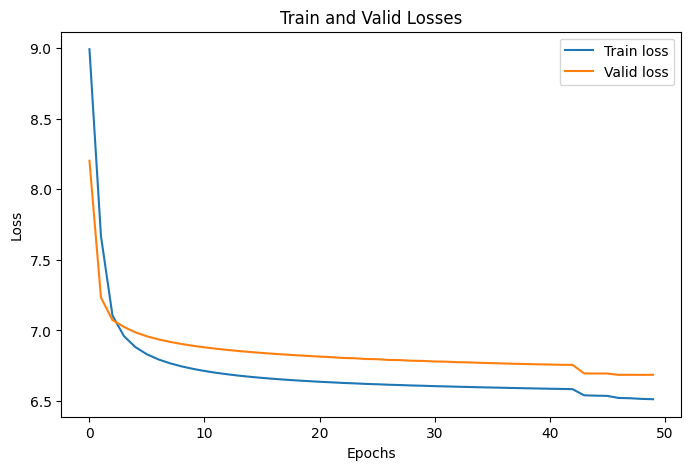

In [ ]:
plt.figure(num = 3, figsize=(8, 5)).patch.set_facecolor('white')
plt.title('Train and Valid Losses')
plt.ylabel('Loss')
plt.xlabel('Epochs')
plt.plot(sampled_epoch, train_losses, label='Train loss')
plt.plot(sampled_epoch, valid_losses, label='Valid loss')
plt.legend()
plt.show()

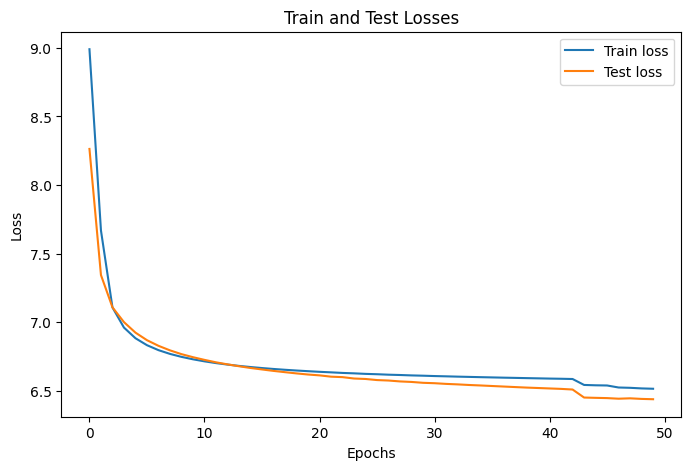

In [ ]:
plt.figure(num = 3, figsize=(8, 5)).patch.set_facecolor('white')
plt.title('Train and Test Losses')
plt.ylabel('Loss')
plt.xlabel('Epochs')
plt.plot(sampled_epoch, train_losses, label='Train loss')
plt.plot(sampled_epoch, test_losses, label='Test loss')
plt.legend()
plt.show()

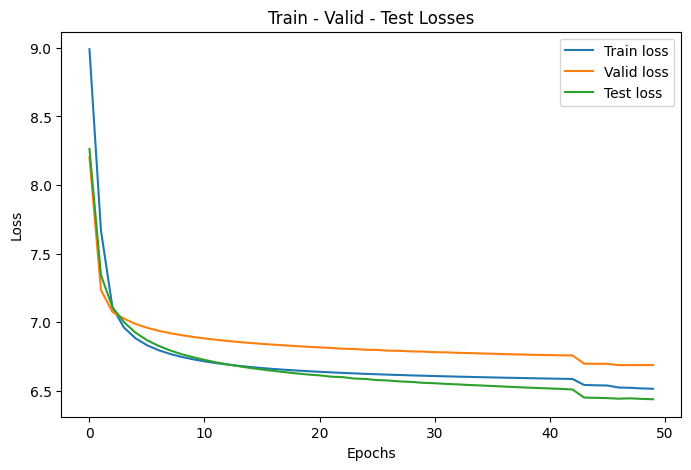

In [ ]:
plt.figure(num = 3, figsize=(8, 5)).patch.set_facecolor('white')
plt.title('Train - Valid - Test Losses')
plt.ylabel('Loss')
plt.xlabel('Epochs')
plt.plot(sampled_epoch, train_losses, label='Train loss')
plt.plot(sampled_epoch, valid_losses, label='Valid loss')
plt.plot(sampled_epoch, test_losses, label='Test loss')
plt.legend()
plt.show()

## Conclusion
The perfomance is too low to make this method available for insights. For this reason I decided to discard this approach (the results are not reported neither in the final report).

# Improving LSTM: Embedding Dropout LSTM
As suggested in Merity et al. one way to improve LSTM performance is to apply some regularization techniques. Since the LSTM is composed of 3 layers at least (Embedding layer, LSTM layer and Output layer) I explore the effects of various types of Dropout adding them once at a time.
I also modify the structure of the recurrent network as follow


1.  400 embedding units;
2.  400 hidden units;
3.  3 LSTM layers;
4.  1 classification layer.




I first define the LSTM class again with the built-in *embedding_dropout* method and the *tying weights* condition. It samples a mask from a Bernoulli distribution and applies it to the embedding layer

In [67]:
class LSTM_Dropout(nn.Module):
    def __init__(self, vocab_size, embedding_dim, hidden_dim, num_layers, pad_idx,
                 device):

        super().__init__()
        self.num_layers = num_layers
        self.hidden_dim = hidden_dim
        self.embedding_dim = embedding_dim
        self.pad_value = pad_idx

        self.embedding = nn.Embedding(vocab_size, embedding_dim, padding_idx=pad_idx)

        self.lstm = nn.LSTM(embedding_dim, hidden_dim, num_layers=num_layers,
                    batch_first=True)

        self.fc = nn.Linear(hidden_dim, vocab_size)

        if tie_weights:
            assert embedding_dim == hidden_dim, 'cannot tie, check dims'
            self.embedding.weight = self.fc.weight


    def embedding_dropout(self, embed, words, p=0.1):
        """
        Taken from original authors code.
        TODO: re-write and add test
        """
        if not self.training:
            masked_embed_weight = embed.weight
        elif not p:
            masked_embed_weight = embed.weight
        else:
            mask = embed.weight.data.new().resize_((embed.weight.size(0), 1)).bernoulli_(1 - p).expand_as(embed.weight) / (1 - p)
            masked_embed_weight = mask * embed.weight

        padding_idx = embed.padding_idx
        if padding_idx is None:
            padding_idx = -1

        X = F.embedding(words, masked_embed_weight,
                        padding_idx, embed.max_norm, embed.norm_type,
                        embed.scale_grad_by_freq, embed.sparse)
        return X

    def forward(self, src, hidden, lengths):

        embedding = self.embedding_dropout(self.embedding, src)
        packed_input = pack_padded_sequence(embedding, lengths, batch_first = True)
        output, hidden = self.lstm(packed_input)
        utt_encoded, input_sizes = pad_packed_sequence(output, batch_first=True, padding_value=self.pad_value)
        prediction = self.fc(utt_encoded)
        prediction = prediction.reshape(prediction.size(0)*prediction.size(1), prediction.size(2))
        return prediction, hidden

    def init_weights(self):
        init_range_emb = 0.1
        init_range_other = 1/math.sqrt(self.hidden_dim)
        self.embedding.weight.data.uniform_(-init_range_emb, init_range_emb)
        self.fc.weight.data.uniform_(-init_range_other, init_range_other)
        self.fc.bias.data.zero_()

        for i in range(self.num_layers):
            self.lstm.all_weights[i][0] = torch.FloatTensor(self.embedding_dim,
                    self.hidden_dim).uniform_(-init_range_other, init_range_other)
            self.lstm.all_weights[i][1] = torch.FloatTensor(self.hidden_dim,
                    self.hidden_dim).uniform_(-init_range_other, init_range_other)

    def init_hidden(self, batch_size, device):
        hidden = torch.zeros(self.num_layers, batch_size, self.hidden_dim).to(device)
        cell = torch.zeros(self.num_layers,  batch_size, self.hidden_dim).to(device)

        return hidden, cell

    def detach_hidden(self, hidden):
        hidden, cell = hidden
        hidden = hidden.detach()
        cell = cell.detach()

        return hidden, cell

## Define new architecture
Along with the embedding dropout I decided, taking inspiration by the paper of Merity et. al, to augment the model's dimensions of the hidden and embedding's representations. Moreover, I set the *num_layer* parameter (LSTM layers) to 3.

In [68]:
vocab_size = len(train_dataset.vocab.itos)
embedding_dim = 400
hidden_dim = 400
num_layers = 3
dropout_rate = 0.2
tie_weights = True
lr = 10.0
PAD_TOKEN = 0


In [69]:
lstm_drop = LSTM_Dropout(vocab_size, embedding_dim, hidden_dim, num_layers, PAD_TOKEN, device).to(device)
lstm_drop.apply(init_weights)
optimizer = optim.SGD(lstm_drop.parameters(), lr=lr, momentum=0.9, weight_decay=1e-6)
criterion = nn.CrossEntropyLoss(ignore_index = PAD_TOKEN)
num_params = sum(p.numel() for p in lstm_drop.parameters() if p.requires_grad)
print(f'The model has {num_params:,} trainable parameters')

The model has 7,839,951 trainable parameters


## Main

In [70]:
train_losses_ed = []
valid_losses_ed = []
test_losses_ed = []
sampled_epoch_ed = []
ppl_score_ed_val = []
ppl_score_ed_test = []
patience = 5

best_valid_loss = float('inf')
lr_scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, factor=0.1, patience=0)

for epoch in tqdm(range(N_EPOCHS)):

  print('\nEpoch', epoch)
  train_loss = train_loop(lstm_drop, train_dataloader, optimizer, criterion, batch_size, clip, device)
  eval_loss = eval_loop(lstm_drop, valid_dataloader, optimizer, criterion, batch_size, device)
  test_loss = test_loop(lstm_drop, test_dataloader, optimizer, criterion, batch_size, device)
  print(f'\n\tTrain Loss: {train_loss:.3f}')
  print(f'\tValid Loss: {eval_loss:.3f}')
  print(f'\tTest Loss: {test_loss:.3f}')
  print(f'\tTrain Perplexity: {math.exp(train_loss):.3f}')
  print(f'\tValid Perplexity: {math.exp(eval_loss):.3f}')
  print(f'\tTest Perplexity: {math.exp(test_loss):.3f}')
  lr_scheduler.step(eval_loss)
  train_losses_ed.append(train_loss)
  valid_losses_ed.append(eval_loss)
  test_losses_ed.append(test_loss)
  sampled_epoch_ed.append(epoch)
  ppl_score_ed_val.append(math.exp(eval_loss))
  ppl_score_ed_test.append(math.exp(test_loss))


  if eval_loss < best_valid_loss:
    best_valid_loss = eval_loss
    torch.save(lstm_drop.state_dict(), '/content/gdrive/MyDrive/best-val-lstm_ed.pt')
  else:
    patience -= 1
    if patience <= 0: # Early stopping with patience
      break

  0%|          | 0/50 [00:00<?, ?it/s]


Epoch 0

	Train Loss: 5.723
	Valid Loss: 5.209
	Test Loss: 5.210
	Train Perplexity: 305.855
	Valid Perplexity: 182.894
	Test Perplexity: 183.119


  2%|▏         | 1/50 [00:41<33:50, 41.45s/it]


Epoch 1


  4%|▍         | 2/50 [01:22<32:47, 40.99s/it]


	Train Loss: 5.192
	Valid Loss: 5.014
	Test Loss: 5.005
	Train Perplexity: 179.883
	Valid Perplexity: 150.529
	Test Perplexity: 149.123

Epoch 2


  6%|▌         | 3/50 [02:02<31:59, 40.84s/it]


	Train Loss: 5.023
	Valid Loss: 4.945
	Test Loss: 4.924
	Train Perplexity: 151.876
	Valid Perplexity: 140.513
	Test Perplexity: 137.567

Epoch 3


  8%|▊         | 4/50 [02:43<31:17, 40.82s/it]


	Train Loss: 4.915
	Valid Loss: 4.875
	Test Loss: 4.860
	Train Perplexity: 136.259
	Valid Perplexity: 131.003
	Test Perplexity: 129.065

Epoch 4


 10%|█         | 5/50 [03:24<30:35, 40.79s/it]


	Train Loss: 4.826
	Valid Loss: 4.835
	Test Loss: 4.824
	Train Perplexity: 124.737
	Valid Perplexity: 125.878
	Test Perplexity: 124.462

Epoch 5


 12%|█▏        | 6/50 [04:05<29:54, 40.77s/it]


	Train Loss: 4.760
	Valid Loss: 4.806
	Test Loss: 4.794
	Train Perplexity: 116.721
	Valid Perplexity: 122.267
	Test Perplexity: 120.727

Epoch 6


 14%|█▍        | 7/50 [04:45<29:12, 40.75s/it]


	Train Loss: 4.695
	Valid Loss: 4.789
	Test Loss: 4.784
	Train Perplexity: 109.401
	Valid Perplexity: 120.139
	Test Perplexity: 119.587

Epoch 7


 16%|█▌        | 8/50 [05:26<28:29, 40.69s/it]


	Train Loss: 4.642
	Valid Loss: 4.800
	Test Loss: 4.786
	Train Perplexity: 103.748
	Valid Perplexity: 121.473
	Test Perplexity: 119.818

Epoch 8


 18%|█▊        | 9/50 [06:07<27:48, 40.70s/it]


	Train Loss: 4.271
	Valid Loss: 4.579
	Test Loss: 4.573
	Train Perplexity: 71.558
	Valid Perplexity: 97.461
	Test Perplexity: 96.806

Epoch 9


 20%|██        | 10/50 [06:47<27:06, 40.67s/it]


	Train Loss: 4.133
	Valid Loss: 4.569
	Test Loss: 4.558
	Train Perplexity: 62.374
	Valid Perplexity: 96.477
	Test Perplexity: 95.392

Epoch 10


 22%|██▏       | 11/50 [07:28<26:25, 40.66s/it]


	Train Loss: 4.057
	Valid Loss: 4.567
	Test Loss: 4.557
	Train Perplexity: 57.799
	Valid Perplexity: 96.222
	Test Perplexity: 95.253

Epoch 11


 24%|██▍       | 12/50 [08:08<25:44, 40.65s/it]


	Train Loss: 3.995
	Valid Loss: 4.566
	Test Loss: 4.552
	Train Perplexity: 54.332
	Valid Perplexity: 96.131
	Test Perplexity: 94.786

Epoch 12


 26%|██▌       | 13/50 [08:49<25:02, 40.61s/it]


	Train Loss: 3.940
	Valid Loss: 4.573
	Test Loss: 4.557
	Train Perplexity: 51.394
	Valid Perplexity: 96.798
	Test Perplexity: 95.287

Epoch 13


 28%|██▊       | 14/50 [09:29<24:20, 40.58s/it]


	Train Loss: 3.825
	Valid Loss: 4.583
	Test Loss: 4.567
	Train Perplexity: 45.855
	Valid Perplexity: 97.770
	Test Perplexity: 96.293

Epoch 14


 30%|███       | 15/50 [10:10<23:40, 40.58s/it]


	Train Loss: 3.801
	Valid Loss: 4.585
	Test Loss: 4.570
	Train Perplexity: 44.724
	Valid Perplexity: 98.049
	Test Perplexity: 96.555

Epoch 15


 30%|███       | 15/50 [10:50<25:18, 43.40s/it]


	Train Loss: 3.801
	Valid Loss: 4.586
	Test Loss: 4.570
	Train Perplexity: 44.768
	Valid Perplexity: 98.071
	Test Perplexity: 96.574


## Plots

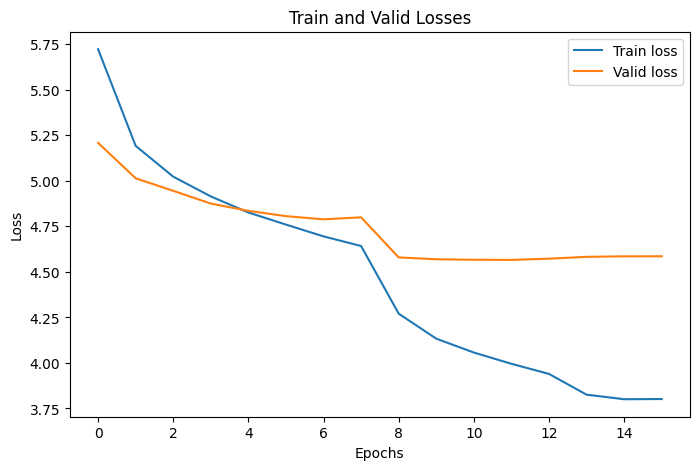

In [71]:
plt.figure(num = 3, figsize=(8, 5)).patch.set_facecolor('white')
plt.title('Train and Valid Losses')
plt.ylabel('Loss')
plt.xlabel('Epochs')
plt.plot(sampled_epoch_ed, train_losses_ed, label='Train loss')
plt.plot(sampled_epoch_ed, valid_losses_ed, label='Valid loss')
plt.legend()
plt.show()

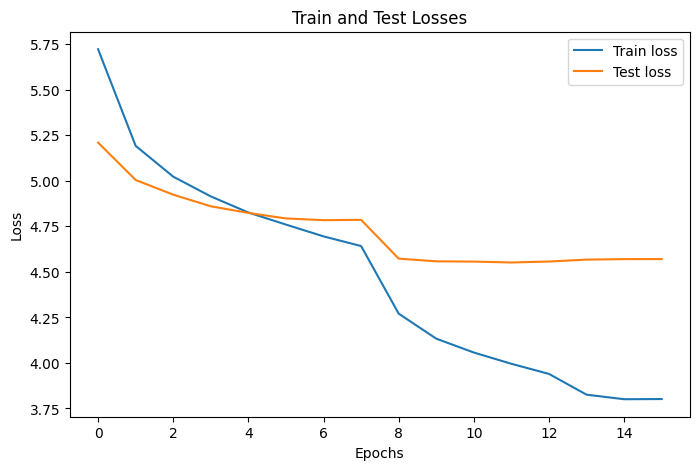

In [72]:
plt.figure(num = 3, figsize=(8, 5)).patch.set_facecolor('white')
plt.title('Train and Test Losses')
plt.ylabel('Loss')
plt.xlabel('Epochs')
plt.plot(sampled_epoch_ed, train_losses_ed, label='Train loss')
plt.plot(sampled_epoch_ed, test_losses_ed, label='Test loss')
plt.legend()
plt.show()

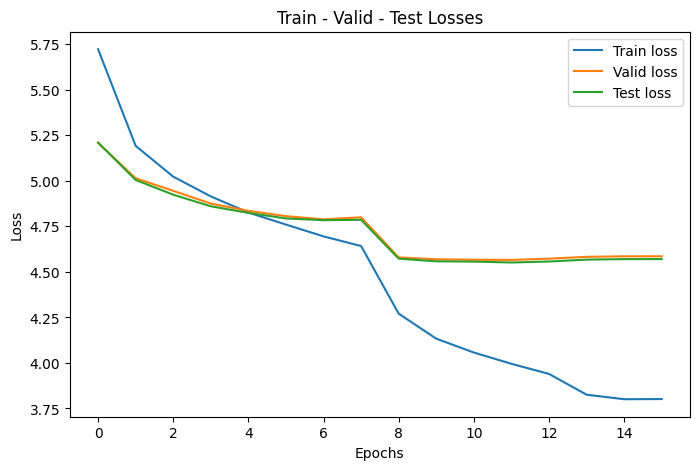

In [73]:
plt.figure(num = 3, figsize=(8, 5)).patch.set_facecolor('white')
plt.title('Train - Valid - Test Losses')
plt.ylabel('Loss')
plt.xlabel('Epochs')
plt.plot(sampled_epoch_ed, train_losses_ed, label='Train loss')
plt.plot(sampled_epoch_ed, valid_losses_ed, label='Valid loss')
plt.plot(sampled_epoch_ed, test_losses_ed, label='Test loss')
plt.legend()
plt.show()

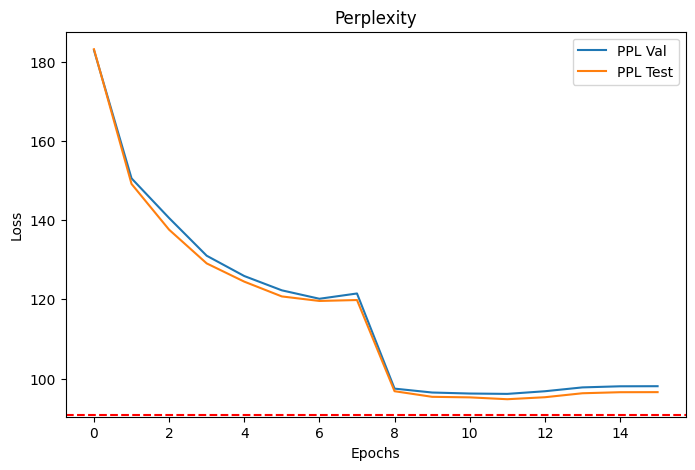

In [74]:
plt.figure(num = 3, figsize=(8, 5)).patch.set_facecolor('white')
plt.title('Perplexity')
plt.ylabel('PPL')
plt.xlabel('Epochs')
plt.plot(sampled_epoch_ed, ppl_score_ed_val, label='PPL Val')
plt.plot(sampled_epoch_ed, ppl_score_ed_test, label='PPL Test')
plt.axhline(y=90.7, color='r', linestyle='--')
plt.legend()
plt.savefig('ppl_ed.png')
plt.show()

## Sentence generation

In [ ]:
lstm_drop.load_state_dict(torch.load('/content/gdrive/MyDrive/best-val-lstm_ed.pt'))

<All keys matched successfully>

In [ ]:
print(' '.join(generate_sentence(lstm_drop, 'the', train_dataset.vocab)))

the company has been negotiating with the u.s. and jaguar officials of the u.s. auto maker eos


In [ ]:
print(' '.join(generate_sentence(lstm_drop, 'a', train_dataset.vocab)))

a spokesman said he was pleased with the company that the company had been negotiating a new bid to buy N N of the company


In [ ]:
print(' '.join(generate_sentence(lstm_drop, 'new york', train_dataset.vocab)))

new york city bonds were priced to yield from about half to N in late december N and may be offered at a rate of


In [ ]:
print(' '.join(generate_sentence(lstm_drop, 'he said many of the countries', train_dataset.vocab)))

he said many of the countries are taking a hard time eos


## Conclusions
We can notice that applying a dropout mask on the embedding layer leads to better results than the vanilla LSTM. The perplexity is nearer the baseline provided, but it is not enough to outperform it. As for the baseline model, the embedding dropout does not avoid the LSTM to trigger the early stopping, indeed after around 18 epochs the training stops. Moreover, the loss reveals some strange "step" during learning.

Starting from this, we can try to go deeper in regularization analysis and implement all the other techniques in [Merity et al.](https://arxiv.org/abs/1708.02182)

# Improving LSTM: Embedding Dropout - Variational Dropout LSTM

## Locked Dropout class
Locked Dropout class for applying Variational Dropout to the LSTM.

In [75]:
class LockedDropout(nn.Module):
  def __init__(self, p=0.4):
    self.p = p
    super().__init__()

  def forward(self, x):
    """
        Args:
            x (:class:`torch.FloatTensor` [sequence length, batch size, rnn hidden size]): Input to
                apply dropout too.
        """
    if not self.training or not self.p:
      return x
    x = x.clone()
    mask = x.new_empty(1, x.size(1), x.size(2), requires_grad=False).bernoulli_(1 - self.p)
    mask = mask.div_(1 - self.p)
    mask = mask.expand_as(x)
    return x * mask


  def __repr__(self):
    return self.__class__.__name__ + '(' \
            + 'p=' + str(self.p) + ')'


## AWD_LSTM class
Even if I haven't spoken about Weight Drop yet, I implement the final class with the option for applying it. This is done for avoiding to implement another class similar to this. I continue to add the dropout techniques one at a time.

In [113]:
class AWD_LSTM(nn.Module):
    def __init__(self, vocab_size, embedding_dim, hidden_dim, num_layers, dropout_rate,
                 device, pad_idx = 0):

        super().__init__()
        self.num_layers = num_layers
        self.hidden_dim = hidden_dim
        self.embedding_dim = embedding_dim
        self.pad_value = pad_idx

        self.embedding = nn.Embedding(vocab_size, embedding_dim, padding_idx=pad_idx)
        self.lstm = nn.LSTM(embedding_dim, hidden_dim, num_layers=num_layers,
                    dropout=dropout_rate, batch_first=True)
        self.in_lock_dp = LockedDropout()

        self.out_lock_dp = LockedDropout()
        self.fc = nn.Linear(hidden_dim, vocab_size)

        if tie_weights:
            assert embedding_dim == hidden_dim, 'cannot tie, check dims'
            self.embedding.weight = self.fc.weight

        if dropout_rate:
            self.lstm = WeightDrop(self.lstm, ['weight_hh_l1', 'weight_hh_l2'], dropout=dropout_rate)
            #self.lstm = WeightDrop(self.lstm, ['weight_hh_l2'], dropout=dropout_rate)

    def embedding_dropout(self, embed, words, p=0.1):
        """
        Taken from original authors code.
        TODO: re-write and add test
        """
        if not self.training:
            masked_embed_weight = embed.weight
        elif not p:
            masked_embed_weight = embed.weight
        else:
            mask = embed.weight.data.new().resize_((embed.weight.size(0), 1)).bernoulli_(1 - p).expand_as(embed.weight) / (1 - p)
            masked_embed_weight = mask * embed.weight

        padding_idx = embed.padding_idx
        if padding_idx is None:
            padding_idx = -1

        X = F.embedding(words, masked_embed_weight,
                        padding_idx, embed.max_norm, embed.norm_type,
                        embed.scale_grad_by_freq, embed.sparse)
        return X

    def forward(self, src, hidden, lengths):

        embedding = self.embedding_dropout(self.embedding, src)
        embedding = self.in_lock_dp(embedding)
        packed_input = pack_padded_sequence(embedding, lengths, batch_first = True)
        if hidden is not None:
            h_n, c_n = hidden
            h_n = h_n[:, :src.shape[0], :]
            c_n = c_n[:, :src.shape[0], :]
            hidden = [h_n, c_n]
        output, hidden = self.lstm(packed_input)
        utt_encoded, input_sizes = pad_packed_sequence(output, batch_first=True, padding_value=self.pad_value)
        utt_encoded = self.out_lock_dp(utt_encoded)
        prediction = self.fc(utt_encoded)
        prediction = prediction.reshape(prediction.size(0)*prediction.size(1), prediction.size(2))

        return prediction, hidden

    def init_weights(self):
        init_range_emb = 0.1
        init_range_other = 1/math.sqrt(self.hidden_dim)
        self.embedding.weight.data.uniform_(-init_range_emb, init_range_emb)
        self.fc.weight.data.uniform_(-init_range_other, init_range_other)
        self.fc.bias.data.zero_()

        for i in range(self.num_layers):
            self.lstm.all_weights[i][0] = torch.FloatTensor(self.embedding_dim,
                    self.hidden_dim).uniform_(-init_range_other, init_range_other)
            self.lstm.all_weights[i][1] = torch.FloatTensor(self.hidden_dim,
                    self.hidden_dim).uniform_(-init_range_other, init_range_other)

    def init_hidden(self, batch_size, device):
        hidden = torch.zeros(self.num_layers, batch_size, self.hidden_dim).to(device)

        cell = torch.zeros(self.num_layers,  batch_size, self.hidden_dim).to(device)


        return hidden, cell

    def detach_hidden(self, hidden):
        hidden, cell = hidden
        hidden = hidden.detach()
        cell = cell.detach()

        return hidden, cell

## Main

In [77]:
lstm_ed_vd = AWD_LSTM(vocab_size, embedding_dim, hidden_dim, num_layers, PAD_TOKEN, device).to(device)
lstm_ed_vd.apply(init_weights)
optimizer = optim.SGD(lstm_ed_vd.parameters(), lr=lr, momentum=0.9, weight_decay=1e-6)
criterion = nn.CrossEntropyLoss(ignore_index = PAD_TOKEN)
num_params = sum(p.numel() for p in lstm_ed_vd.parameters() if p.requires_grad)
print(f'The model has {num_params:,} trainable parameters')

The model has 7,839,951 trainable parameters


In [78]:
train_losses_ed_vd = []
valid_losses_ed_vd = []
test_losses_ed_vd = []
sampled_epoch_ed_vd = []
ppl_score_ed_vd_val = []
ppl_score_ed_vd_test = []
patience = 5

best_valid_loss = float('inf')
lr_scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, factor=0.1, patience=0)

for epoch in tqdm(range(N_EPOCHS)):

  print('\nEpoch', epoch)
  train_loss = train_loop(lstm_ed_vd, train_dataloader, optimizer, criterion, batch_size, clip, device)
  eval_loss = eval_loop(lstm_ed_vd, valid_dataloader, optimizer, criterion, batch_size, device)
  test_loss = test_loop(lstm_ed_vd, test_dataloader, optimizer, criterion, batch_size, device)
  print(f'\n\tTrain Loss: {train_loss:.3f}')
  print(f'\tValid Loss: {eval_loss:.3f}')
  print(f'\tTest Loss: {test_loss:.3f}')
  print(f'\tTrain Perplexity: {math.exp(train_loss):.3f}')
  print(f'\tValid Perplexity: {math.exp(eval_loss):.3f}')
  print(f'\tTest Perplexity: {math.exp(test_loss):.3f}')
  lr_scheduler.step(eval_loss)
  train_losses_ed_vd.append(train_loss)
  valid_losses_ed_vd.append(eval_loss)
  test_losses_ed_vd.append(test_loss)
  sampled_epoch_ed_vd.append(epoch)
  ppl_score_ed_vd_val.append(math.exp(eval_loss))
  ppl_score_ed_vd_test.append(math.exp(test_loss))



  if eval_loss < best_valid_loss:
    best_valid_loss = eval_loss
    torch.save(lstm_ed_vd.state_dict(), '/content/gdrive/MyDrive/best-val-lstm_ed_vd.pt')
  else:
    patience -= 1
    if patience <= 0: # Early stopping with patience
      break

  0%|          | 0/50 [00:00<?, ?it/s]


Epoch 0

	Train Loss: 5.860
	Valid Loss: 5.279
	Test Loss: 5.278
	Train Perplexity: 350.854
	Valid Perplexity: 196.239
	Test Perplexity: 195.985


  2%|▏         | 1/50 [00:41<34:15, 41.94s/it]


Epoch 1


  4%|▍         | 2/50 [01:22<32:58, 41.22s/it]


	Train Loss: 5.431
	Valid Loss: 5.115
	Test Loss: 5.099
	Train Perplexity: 228.348
	Valid Perplexity: 166.520
	Test Perplexity: 163.881

Epoch 2


  6%|▌         | 3/50 [02:03<32:08, 41.03s/it]


	Train Loss: 5.342
	Valid Loss: 5.077
	Test Loss: 5.062
	Train Perplexity: 208.935
	Valid Perplexity: 160.306
	Test Perplexity: 157.926

Epoch 3


  8%|▊         | 4/50 [02:45<31:39, 41.29s/it]


	Train Loss: 5.301
	Valid Loss: 5.048
	Test Loss: 5.031
	Train Perplexity: 200.536
	Valid Perplexity: 155.687
	Test Perplexity: 153.057

Epoch 4


 10%|█         | 5/50 [03:25<30:47, 41.05s/it]


	Train Loss: 5.268
	Valid Loss: 5.005
	Test Loss: 5.000
	Train Perplexity: 194.009
	Valid Perplexity: 149.210
	Test Perplexity: 148.339

Epoch 5


 12%|█▏        | 6/50 [04:06<30:01, 40.94s/it]


	Train Loss: 5.241
	Valid Loss: 4.986
	Test Loss: 4.972
	Train Perplexity: 188.881
	Valid Perplexity: 146.353
	Test Perplexity: 144.347

Epoch 6


 14%|█▍        | 7/50 [04:47<29:16, 40.85s/it]


	Train Loss: 5.222
	Valid Loss: 4.960
	Test Loss: 4.947
	Train Perplexity: 185.370
	Valid Perplexity: 142.579
	Test Perplexity: 140.693

Epoch 7


 16%|█▌        | 8/50 [05:27<28:33, 40.79s/it]


	Train Loss: 5.197
	Valid Loss: 4.941
	Test Loss: 4.929
	Train Perplexity: 180.740
	Valid Perplexity: 139.867
	Test Perplexity: 138.211

Epoch 8


 18%|█▊        | 9/50 [06:08<27:50, 40.75s/it]


	Train Loss: 5.172
	Valid Loss: 4.926
	Test Loss: 4.916
	Train Perplexity: 176.324
	Valid Perplexity: 137.783
	Test Perplexity: 136.512

Epoch 9


 20%|██        | 10/50 [06:49<27:09, 40.74s/it]


	Train Loss: 5.148
	Valid Loss: 4.904
	Test Loss: 4.886
	Train Perplexity: 172.078
	Valid Perplexity: 134.807
	Test Perplexity: 132.466

Epoch 10


 22%|██▏       | 11/50 [07:29<26:28, 40.72s/it]


	Train Loss: 5.131
	Valid Loss: 4.888
	Test Loss: 4.869
	Train Perplexity: 169.107
	Valid Perplexity: 132.650
	Test Perplexity: 130.133

Epoch 11


 24%|██▍       | 12/50 [08:10<25:45, 40.67s/it]


	Train Loss: 5.112
	Valid Loss: 4.909
	Test Loss: 4.899
	Train Perplexity: 166.039
	Valid Perplexity: 135.460
	Test Perplexity: 134.136

Epoch 12


 26%|██▌       | 13/50 [08:51<25:04, 40.67s/it]


	Train Loss: 4.910
	Valid Loss: 4.712
	Test Loss: 4.698
	Train Perplexity: 135.687
	Valid Perplexity: 111.240
	Test Perplexity: 109.776

Epoch 13


 28%|██▊       | 14/50 [09:31<24:23, 40.66s/it]


	Train Loss: 4.836
	Valid Loss: 4.680
	Test Loss: 4.670
	Train Perplexity: 125.928
	Valid Perplexity: 107.775
	Test Perplexity: 106.664

Epoch 14


 30%|███       | 15/50 [10:12<23:43, 40.68s/it]


	Train Loss: 4.797
	Valid Loss: 4.655
	Test Loss: 4.645
	Train Perplexity: 121.199
	Valid Perplexity: 105.128
	Test Perplexity: 104.097

Epoch 15


 32%|███▏      | 16/50 [10:53<23:02, 40.66s/it]


	Train Loss: 4.768
	Valid Loss: 4.639
	Test Loss: 4.626
	Train Perplexity: 117.674
	Valid Perplexity: 103.487
	Test Perplexity: 102.138

Epoch 16


 34%|███▍      | 17/50 [11:33<22:21, 40.65s/it]


	Train Loss: 4.740
	Valid Loss: 4.628
	Test Loss: 4.617
	Train Perplexity: 114.464
	Valid Perplexity: 102.287
	Test Perplexity: 101.180

Epoch 17


 36%|███▌      | 18/50 [12:14<21:42, 40.69s/it]


	Train Loss: 4.719
	Valid Loss: 4.611
	Test Loss: 4.602
	Train Perplexity: 112.072
	Valid Perplexity: 100.631
	Test Perplexity: 99.649

Epoch 18


 38%|███▊      | 19/50 [12:55<21:01, 40.70s/it]


	Train Loss: 4.694
	Valid Loss: 4.600
	Test Loss: 4.591
	Train Perplexity: 109.332
	Valid Perplexity: 99.511
	Test Perplexity: 98.607

Epoch 19


 40%|████      | 20/50 [13:35<20:21, 40.70s/it]


	Train Loss: 4.680
	Valid Loss: 4.585
	Test Loss: 4.575
	Train Perplexity: 107.721
	Valid Perplexity: 98.010
	Test Perplexity: 97.002

Epoch 20


 42%|████▏     | 21/50 [14:16<19:40, 40.72s/it]


	Train Loss: 4.657
	Valid Loss: 4.577
	Test Loss: 4.565
	Train Perplexity: 105.311
	Valid Perplexity: 97.219
	Test Perplexity: 96.083

Epoch 21


 44%|████▍     | 22/50 [14:57<19:00, 40.72s/it]


	Train Loss: 4.642
	Valid Loss: 4.569
	Test Loss: 4.558
	Train Perplexity: 103.774
	Valid Perplexity: 96.411
	Test Perplexity: 95.424

Epoch 22


 46%|████▌     | 23/50 [15:38<18:18, 40.70s/it]


	Train Loss: 4.622
	Valid Loss: 4.560
	Test Loss: 4.548
	Train Perplexity: 101.714
	Valid Perplexity: 95.550
	Test Perplexity: 94.404

Epoch 23


 48%|████▊     | 24/50 [16:18<17:38, 40.72s/it]


	Train Loss: 4.606
	Valid Loss: 4.550
	Test Loss: 4.537
	Train Perplexity: 100.108
	Valid Perplexity: 94.669
	Test Perplexity: 93.441

Epoch 24


 50%|█████     | 25/50 [16:59<16:58, 40.72s/it]


	Train Loss: 4.590
	Valid Loss: 4.547
	Test Loss: 4.533
	Train Perplexity: 98.473
	Valid Perplexity: 94.331
	Test Perplexity: 93.035

Epoch 25


 52%|█████▏    | 26/50 [17:40<16:16, 40.71s/it]


	Train Loss: 4.579
	Valid Loss: 4.536
	Test Loss: 4.522
	Train Perplexity: 97.433
	Valid Perplexity: 93.308
	Test Perplexity: 91.991

Epoch 26


 54%|█████▍    | 27/50 [18:21<15:36, 40.72s/it]


	Train Loss: 4.558
	Valid Loss: 4.530
	Test Loss: 4.520
	Train Perplexity: 95.347
	Valid Perplexity: 92.718
	Test Perplexity: 91.801

Epoch 27


 56%|█████▌    | 28/50 [19:01<14:56, 40.74s/it]


	Train Loss: 4.547
	Valid Loss: 4.525
	Test Loss: 4.513
	Train Perplexity: 94.306
	Valid Perplexity: 92.256
	Test Perplexity: 91.163

Epoch 28


 58%|█████▊    | 29/50 [19:42<14:15, 40.74s/it]


	Train Loss: 4.524
	Valid Loss: 4.516
	Test Loss: 4.509
	Train Perplexity: 92.245
	Valid Perplexity: 91.487
	Test Perplexity: 90.810

Epoch 29


 60%|██████    | 30/50 [20:23<13:36, 40.81s/it]


	Train Loss: 4.514
	Valid Loss: 4.508
	Test Loss: 4.497
	Train Perplexity: 91.242
	Valid Perplexity: 90.731
	Test Perplexity: 89.750

Epoch 30


 62%|██████▏   | 31/50 [21:04<12:56, 40.87s/it]


	Train Loss: 4.502
	Valid Loss: 4.501
	Test Loss: 4.493
	Train Perplexity: 90.196
	Valid Perplexity: 90.114
	Test Perplexity: 89.370

Epoch 31


 64%|██████▍   | 32/50 [21:45<12:16, 40.92s/it]


	Train Loss: 4.481
	Valid Loss: 4.493
	Test Loss: 4.486
	Train Perplexity: 88.289
	Valid Perplexity: 89.388
	Test Perplexity: 88.733

Epoch 32


 66%|██████▌   | 33/50 [22:26<11:35, 40.93s/it]


	Train Loss: 4.470
	Valid Loss: 4.490
	Test Loss: 4.483
	Train Perplexity: 87.393
	Valid Perplexity: 89.092
	Test Perplexity: 88.542

Epoch 33


 68%|██████▊   | 34/50 [23:07<10:55, 40.95s/it]


	Train Loss: 4.458
	Valid Loss: 4.487
	Test Loss: 4.481
	Train Perplexity: 86.287
	Valid Perplexity: 88.814
	Test Perplexity: 88.326

Epoch 34


 70%|███████   | 35/50 [23:48<10:14, 40.96s/it]


	Train Loss: 4.442
	Valid Loss: 4.479
	Test Loss: 4.473
	Train Perplexity: 84.979
	Valid Perplexity: 88.139
	Test Perplexity: 87.656

Epoch 35


 72%|███████▏  | 36/50 [24:29<09:33, 40.94s/it]


	Train Loss: 4.429
	Valid Loss: 4.482
	Test Loss: 4.478
	Train Perplexity: 83.818
	Valid Perplexity: 88.435
	Test Perplexity: 88.017

Epoch 36


 74%|███████▍  | 37/50 [25:10<08:52, 40.95s/it]


	Train Loss: 4.373
	Valid Loss: 4.469
	Test Loss: 4.464
	Train Perplexity: 79.316
	Valid Perplexity: 87.312
	Test Perplexity: 86.852

Epoch 37


 76%|███████▌  | 38/50 [25:51<08:11, 40.97s/it]


	Train Loss: 4.360
	Valid Loss: 4.466
	Test Loss: 4.462
	Train Perplexity: 78.285
	Valid Perplexity: 86.984
	Test Perplexity: 86.638

Epoch 38


 78%|███████▊  | 39/50 [26:32<07:30, 40.95s/it]


	Train Loss: 4.355
	Valid Loss: 4.466
	Test Loss: 4.461
	Train Perplexity: 77.844
	Valid Perplexity: 86.998
	Test Perplexity: 86.589

Epoch 39


 80%|████████  | 40/50 [27:13<06:49, 40.96s/it]


	Train Loss: 4.350
	Valid Loss: 4.465
	Test Loss: 4.461
	Train Perplexity: 77.482
	Valid Perplexity: 86.927
	Test Perplexity: 86.560

Epoch 40


 82%|████████▏ | 41/50 [27:54<06:08, 40.99s/it]


	Train Loss: 4.342
	Valid Loss: 4.464
	Test Loss: 4.460
	Train Perplexity: 76.830
	Valid Perplexity: 86.855
	Test Perplexity: 86.511

Epoch 41


 84%|████████▍ | 42/50 [28:35<05:27, 40.96s/it]


	Train Loss: 4.345
	Valid Loss: 4.465
	Test Loss: 4.461
	Train Perplexity: 77.107
	Valid Perplexity: 86.888
	Test Perplexity: 86.544

Epoch 42


 84%|████████▍ | 42/50 [29:16<05:34, 41.81s/it]


	Train Loss: 4.343
	Valid Loss: 4.465
	Test Loss: 4.461
	Train Perplexity: 76.966
	Valid Perplexity: 86.879
	Test Perplexity: 86.533


## Plots

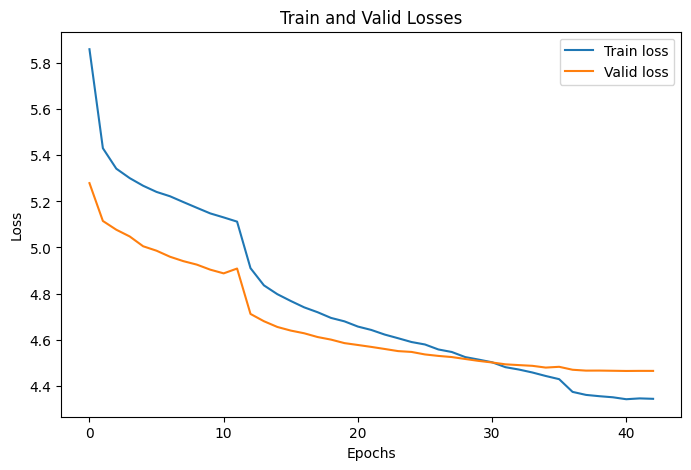

In [79]:
plt.figure(num = 3, figsize=(8, 5)).patch.set_facecolor('white')
plt.title('Train and Valid Losses')
plt.ylabel('Loss')
plt.xlabel('Epochs')
plt.plot(sampled_epoch_ed_vd, train_losses_ed_vd, label='Train loss')
plt.plot(sampled_epoch_ed_vd, valid_losses_ed_vd, label='Valid loss')
plt.legend()
plt.show()

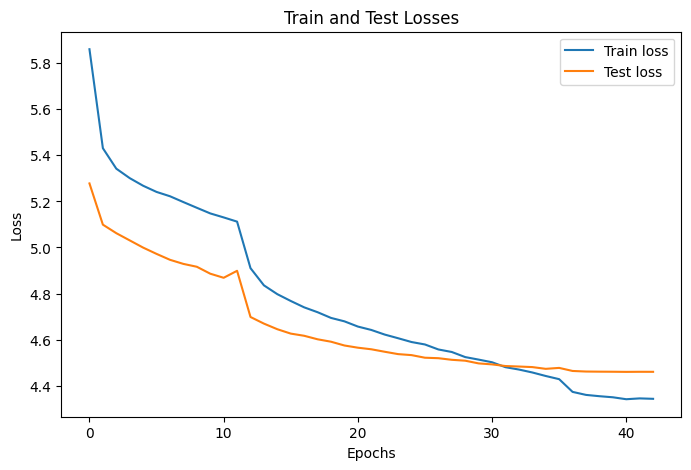

In [80]:
plt.figure(num = 3, figsize=(8, 5)).patch.set_facecolor('white')
plt.title('Train and Test Losses')
plt.ylabel('Loss')
plt.xlabel('Epochs')
plt.plot(sampled_epoch_ed_vd, train_losses_ed_vd, label='Train loss')
plt.plot(sampled_epoch_ed_vd, test_losses_ed_vd, label='Test loss')
plt.legend()
plt.show()

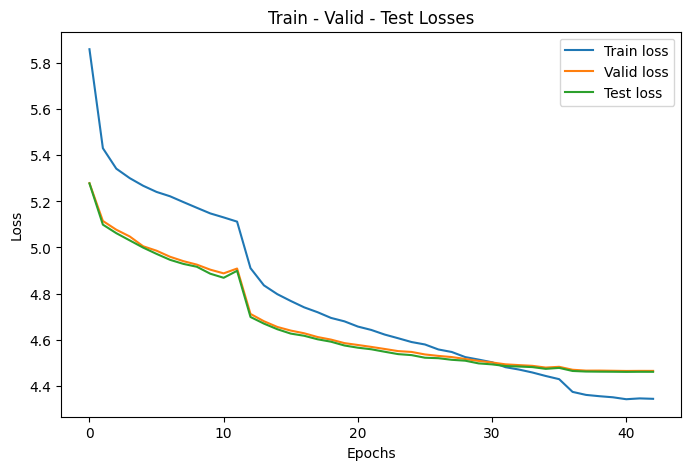

In [81]:
plt.figure(num = 3, figsize=(8, 5)).patch.set_facecolor('white')
plt.title('Train - Valid - Test Losses')
plt.ylabel('Loss')
plt.xlabel('Epochs')
plt.plot(sampled_epoch_ed_vd, train_losses_ed_vd, label='Train loss')
plt.plot(sampled_epoch_ed_vd, valid_losses_ed_vd, label='Valid loss')
plt.plot(sampled_epoch_ed_vd, test_losses_ed_vd, label='Test loss')
plt.legend()
plt.show()

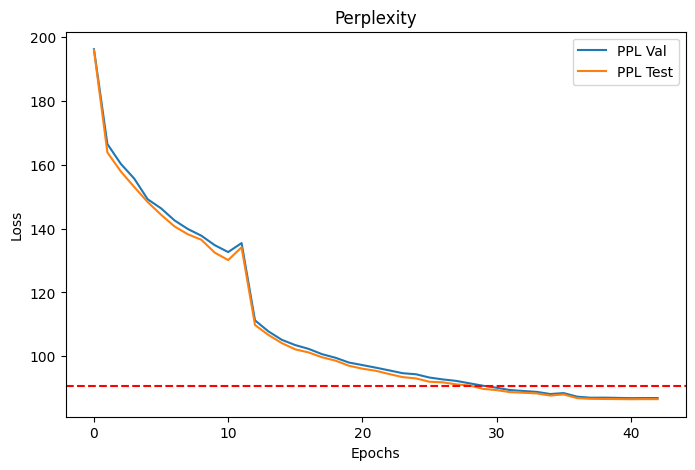

In [82]:
plt.figure(num = 3, figsize=(8, 5)).patch.set_facecolor('white')
plt.title('Perplexity')
plt.ylabel('PPL')
plt.xlabel('Epochs')
plt.plot(sampled_epoch_ed_vd, ppl_score_ed_vd_val, label='PPL Val')
plt.plot(sampled_epoch_ed_vd, ppl_score_ed_vd_test, label='PPL Test')
plt.axhline(y=90.7, color='r', linestyle='--')
plt.legend()
plt.savefig('ppl_ed_vd.png')
plt.show()

## Sentence generation

In [ ]:
lstm_ed_vd.load_state_dict(torch.load('/content/gdrive/MyDrive/best-val-lstm_ed_vd.pt'))

<All keys matched successfully>

In [ ]:
print(' '.join(generate_sentence(lstm_ed_vd, 'the', train_dataset.vocab)))

the company 's stock was quoted late yesterday at about a N N lower eos


In [ ]:
print(' '.join(generate_sentence(lstm_ed_vd, 'a', train_dataset.vocab)))

a spokesman for the company 's board declined comment eos


In [ ]:
print(' '.join(generate_sentence(lstm_ed_vd, 'new york', train_dataset.vocab)))

new york city 's N N issue of N were quoted late at N to yield about a N point to yield N percentage points


In [ ]:
print(' '.join(generate_sentence(lstm_ed_vd, 'he said many of the countries' , train_dataset.vocab)))

he said many of the countries are n't in the u.s. to make the use of their own eos


## Conclusion
Using both Embedding and Variational Dropouts the model is capable of going beyond the baseline. From the run above the LSTM achieves **86.9 PPL** on the validation set and the loss curve still shows a "step" during the learning. This encourages me to implement the last dropout technique to try to improve more the model's perfomance and behaviour. The PPL on the test set is generally slightly better than the dev set, but the two curves in the third plot show a huge overlap in the pace. As for the two preceding models, the lstm triggers the early stopping before the 50th epoch.

# Improving LSTM - Embedding Dropout - Variational Dropout - Weight Drop LSTM

## Weight Drop
Weight Drop class for applying DropConnect to the recurrent layers of the network


In [83]:
from torch.nn import Parameter

class WeightDrop(torch.nn.Module):
    def __init__(self, module, weights, dropout=0, variational=False):
        super(WeightDrop, self).__init__()
        self.module = module
        self.weights = weights
        self.dropout = dropout
        self.variational = variational
        self._setup()

    def widget_demagnetizer_y2k_edition(*args, **kwargs):
        return

    def _setup(self):
        # Terrible temporary solution to an issue regarding compacting weights re: CUDNN RNN
        if issubclass(type(self.module), torch.nn.RNNBase):
            self.module.flatten_parameters = self.widget_demagnetizer_y2k_edition

        for name_w in self.weights:
            print('Applying weight drop of {} to {}'.format(self.dropout, name_w))
            w = getattr(self.module, name_w)
            del self.module._parameters[name_w]
            self.module.register_parameter(name_w + '_raw', Parameter(w.data))

    def _setweights(self):
        for name_w in self.weights:
            raw_w = getattr(self.module, name_w + '_raw')
            w = None

            if self.variational:
                mask = torch.ones(raw_w.size(0), 1)

                if raw_w.is_cuda: mask = mask.cuda()
                mask = torch.nn.functional.dropout(mask, p=self.dropout, training=True)
                w = mask.expand_as(raw_w) * raw_w
            else:
                w = torch.nn.functional.dropout(raw_w, p=self.dropout, training=self.training)
            setattr(self.module, name_w, Parameter(w))

    def forward(self, *args):
        self._setweights()
        return self.module.forward(*args)


## Main

In [91]:
lstm_ed_vd_wd_2l = AWD_LSTM(vocab_size, embedding_dim, hidden_dim, num_layers, dropout_rate, device).to(device)
lstm_ed_vd_wd_2l.apply(init_weights)
optimizer = optim.SGD(lstm_ed_vd_wd_2l.parameters(), lr=lr)
criterion = nn.CrossEntropyLoss(ignore_index = PAD_TOKEN)
num_params = sum(p.numel() for p in lstm_ed_vd_wd_2l.parameters() if p.requires_grad)
print(f'The model has {num_params:,} trainable parameters')

Applying weight drop of 0.2 to weight_hh_l1
Applying weight drop of 0.2 to weight_hh_l2
The model has 7,839,951 trainable parameters


From this point on, I get rid of the early-stopping technique because I want to let the model to reach its best performance. In fact, looking at the previous runs we can notice that, even if the models are early stopped, they have improved in the last epochs. For this reason I explore the full potential of the LSTM by training it for the whole 50 epochs

In [92]:
train_losses_ed_vd_wd = []
valid_losses_ed_vd_wd = []
test_losses_ed_vd_wd = []
sampled_epoch_ed_vd_wd = []
ppl_score_ed_vd_wd_val = []
ppl_score_ed_vd_wd_test = []

best_valid_loss = float('inf')

for epoch in range(N_EPOCHS):
  print('epoch', epoch)
  train_loss = train_loop(lstm_ed_vd_wd_2l, train_dataloader, optimizer, criterion, batch_size, clip, device)
  eval_loss = eval_loop(lstm_ed_vd_wd_2l, valid_dataloader, optimizer, criterion, batch_size, device)
  test_loss = test_loop(lstm_ed_vd_wd_2l, test_dataloader, optimizer, criterion, batch_size, device)
  print(f'\n\tTrain Loss: {train_loss:.3f}')
  print(f'\tValid Loss: {eval_loss:.3f}')
  print(f'\tTest Loss: {test_loss:.3f}')
  print(f'\tTrain Perplexity: {math.exp(train_loss):.3f}')
  print(f'\tValid Perplexity: {math.exp(eval_loss):.3f}')
  print(f'\tTest Perplexity: {math.exp(test_loss):.3f}')
  if eval_loss < best_valid_loss:
    best_valid_loss = eval_loss
    torch.save(lstm_ed_vd_wd_2l.state_dict(), '/content/gdrive/MyDrive/best-val-lstm_ed_vd_wd_2l_1_2.pt')
  train_losses_ed_vd_wd.append(train_loss)
  valid_losses_ed_vd_wd.append(eval_loss)
  test_losses_ed_vd_wd.append(test_loss)
  sampled_epoch_ed_vd_wd.append(epoch)
  ppl_score_ed_vd_wd_val.append(math.exp(eval_loss))
  ppl_score_ed_vd_wd_test.append(math.exp(test_loss))


epoch 0

	Train Loss: 6.326
	Valid Loss: 5.604
	Test Loss: 5.595
	Train Perplexity: 558.917
	Valid Perplexity: 271.507
	Test Perplexity: 269.156
epoch 1

	Train Loss: 5.606
	Valid Loss: 5.236
	Test Loss: 5.236
	Train Perplexity: 272.131
	Valid Perplexity: 187.971
	Test Perplexity: 187.982
epoch 2

	Train Loss: 5.359
	Valid Loss: 5.055
	Test Loss: 5.048
	Train Perplexity: 212.540
	Valid Perplexity: 156.871
	Test Perplexity: 155.725
epoch 3

	Train Loss: 5.207
	Valid Loss: 4.931
	Test Loss: 4.927
	Train Perplexity: 182.518
	Valid Perplexity: 138.563
	Test Perplexity: 137.962
epoch 4

	Train Loss: 5.098
	Valid Loss: 4.846
	Test Loss: 4.843
	Train Perplexity: 163.658
	Valid Perplexity: 127.197
	Test Perplexity: 126.827
epoch 5

	Train Loss: 5.003
	Valid Loss: 4.775
	Test Loss: 4.772
	Train Perplexity: 148.893
	Valid Perplexity: 118.494
	Test Perplexity: 118.101
epoch 6

	Train Loss: 4.930
	Valid Loss: 4.722
	Test Loss: 4.711
	Train Perplexity: 138.428
	Valid Perplexity: 112.385
	Test Perpl

## Plots


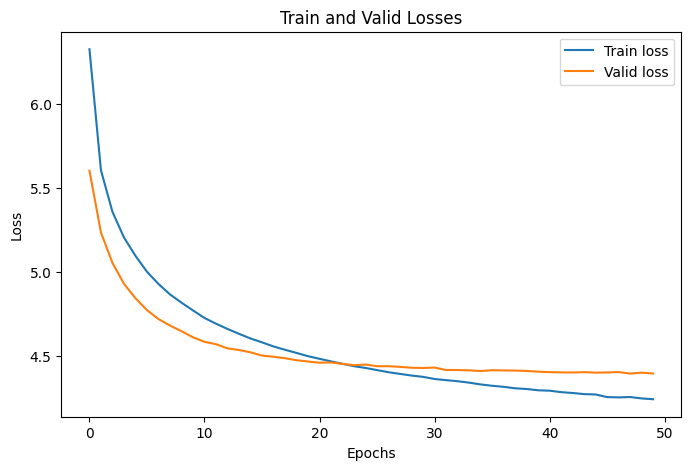

In [93]:
plt.figure(num = 3, figsize=(8, 5)).patch.set_facecolor('white')
plt.title('Train and Valid Losses')
plt.ylabel('Loss')
plt.xlabel('Epochs')
plt.plot(sampled_epoch_ed_vd_wd, train_losses_ed_vd_wd, label='Train loss')
plt.plot(sampled_epoch_ed_vd_wd, valid_losses_ed_vd_wd, label='Valid loss')
plt.legend()
plt.show()

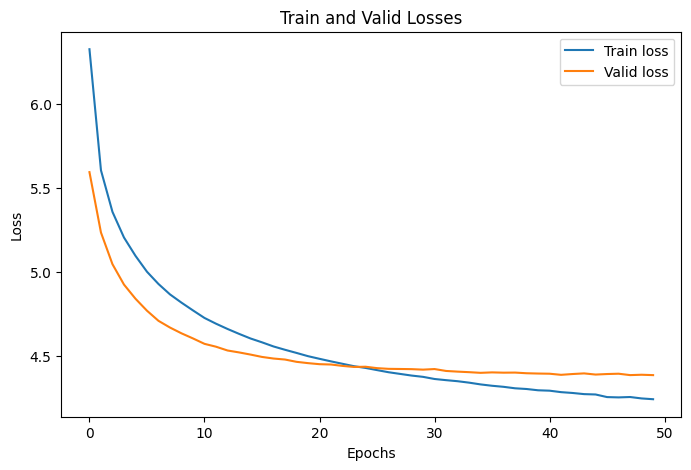

In [94]:
plt.figure(num = 3, figsize=(8, 5)).patch.set_facecolor('white')
plt.title('Train and Valid Losses')
plt.ylabel('Loss')
plt.xlabel('Epochs')
plt.plot(sampled_epoch_ed_vd_wd, train_losses_ed_vd_wd, label='Train loss')
plt.plot(sampled_epoch_ed_vd_wd, test_losses_ed_vd_wd, label='Valid loss')
plt.legend()
plt.show()

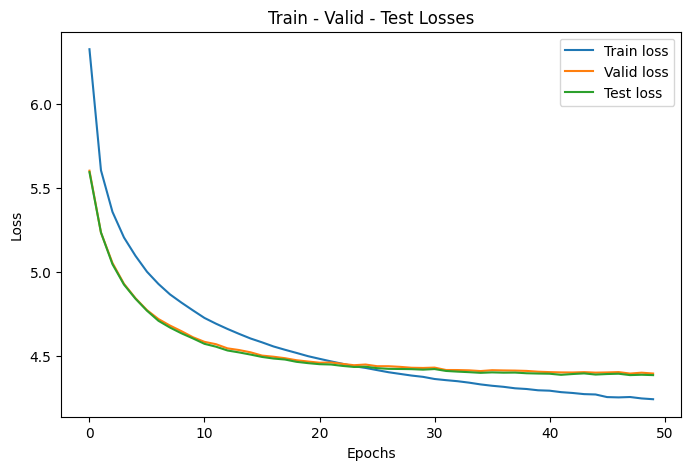

In [95]:
plt.figure(num = 3, figsize=(8, 5)).patch.set_facecolor('white')
plt.title('Train - Valid - Test Losses')
plt.ylabel('Loss')
plt.xlabel('Epochs')
plt.plot(sampled_epoch_ed_vd_wd, train_losses_ed_vd_wd, label='Train loss')
plt.plot(sampled_epoch_ed_vd_wd, valid_losses_ed_vd_wd, label='Valid loss')
plt.plot(sampled_epoch_ed_vd_wd, test_losses_ed_vd_wd, label='Test loss')
plt.legend()
plt.show()

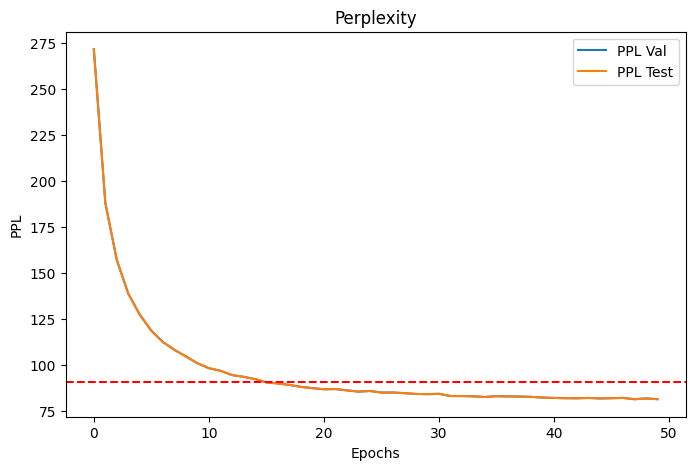

In [96]:
plt.figure(num = 3, figsize=(8, 5)).patch.set_facecolor('white')
plt.title('Perplexity')
plt.ylabel('PPL')
plt.xlabel('Epochs')
plt.plot(sampled_epoch_ed_vd_wd, ppl_score_ed_vd_wd_val, label='PPL Val')
plt.plot(sampled_epoch_ed_vd_wd, ppl_score_ed_vd_wd_test, label='PPL Test')
plt.axhline(y=90.7, color='r', linestyle='--')
plt.legend()
plt.savefig('ppl_ed_vd.png')
plt.show()

## Conclusion
The weight drop technique has revealed very effective on the LSTM. The performances of the model are even better both in validation and test sets. The learning curve seems to be more regular (no more step) with high improvements in the first epochs and then start having a saturated pace. Based on the results of Weight Drop I started an ablation study of this technique applying it progressively on the other recurrent layers.

## Effect of Weight Dropout
Here we try to apply Weight Drop on the other layers of the recurrent part of the LSTM. We change the layers where to apply the technique by manually adding or deleting its name of a particular layer from the AWD_LSTM class.
The LSTM layers' names are:
1. weight_hh_l0
2. weight_hh_l1
3. weight_hh_l2

In [104]:
lstm_ed_vd_wd_1l = AWD_LSTM(vocab_size, embedding_dim, hidden_dim, num_layers, dropout_rate, device).to(device)
lstm_ed_vd_wd_1l.apply(init_weights)
optimizer = optim.SGD(lstm_ed_vd_wd_1l.parameters(), lr=lr)
criterion = nn.CrossEntropyLoss(ignore_index = PAD_TOKEN)
num_params = sum(p.numel() for p in lstm_ed_vd_wd_1l.parameters() if p.requires_grad)
print(f'The model has {num_params:,} trainable parameters')

Applying weight drop of 0.2 to weight_hh_l2
The model has 7,839,951 trainable parameters


In [105]:
train_losses_ed_vd_wd_1 = []
valid_losses_ed_vd_wd_1 = []
test_losses_ed_vd_wd_1 = []
sampled_epoch_ed_vd_wd_1 = []
ppl_score_ed_vd_wd_1_val = []
ppl_score_ed_vd_wd_1_test = []
best_valid_loss = float('inf')

for epoch in range(N_EPOCHS):
  print('epoch', epoch)
  if eval_loss < best_valid_loss:
    best_valid_loss = eval_loss
    torch.save(lstm_ed_vd_wd_1l.state_dict(), '/content/gdrive/MyDrive/best-val-lstm_ed_vd_wd_1l_2.pt')

  train_loss = train_loop(lstm_ed_vd_wd_1l, train_dataloader, optimizer, criterion, batch_size, clip, device)
  eval_loss = eval_loop(lstm_ed_vd_wd_1l, valid_dataloader, optimizer, criterion, batch_size, device)
  test_loss = test_loop(lstm_ed_vd_wd_1l, test_dataloader, optimizer, criterion, batch_size, device)
  print(f'\n\tTrain Loss: {train_loss:.3f}')
  print(f'\tValid Loss: {eval_loss:.3f}')
  print(f'\tTest Loss: {test_loss:.3f}')
  print(f'\tTrain Perplexity: {math.exp(train_loss):.3f}')
  print(f'\tValid Perplexity: {math.exp(eval_loss):.3f}')
  print(f'\tTest Perplexity: {math.exp(test_loss):.3f}')
  train_losses_ed_vd_wd_1.append(train_loss)
  valid_losses_ed_vd_wd_1.append(eval_loss)
  test_losses_ed_vd_wd_1.append(test_loss)
  ppl_score_ed_vd_wd_1_val.append(math.exp(eval_loss))
  ppl_score_ed_vd_wd_1_test.append(math.exp(test_loss))
  sampled_epoch_ed_vd_wd_1.append(epoch)

epoch 0

	Train Loss: 6.299
	Valid Loss: 5.560
	Test Loss: 5.561
	Train Perplexity: 544.104
	Valid Perplexity: 259.779
	Test Perplexity: 260.066
epoch 1

	Train Loss: 5.571
	Valid Loss: 5.203
	Test Loss: 5.203
	Train Perplexity: 262.713
	Valid Perplexity: 181.855
	Test Perplexity: 181.741
epoch 2

	Train Loss: 5.317
	Valid Loss: 5.015
	Test Loss: 5.015
	Train Perplexity: 203.700
	Valid Perplexity: 150.608
	Test Perplexity: 150.599
epoch 3

	Train Loss: 5.159
	Valid Loss: 4.899
	Test Loss: 4.892
	Train Perplexity: 174.065
	Valid Perplexity: 134.189
	Test Perplexity: 133.256
epoch 4

	Train Loss: 5.050
	Valid Loss: 4.814
	Test Loss: 4.805
	Train Perplexity: 156.011
	Valid Perplexity: 123.241
	Test Perplexity: 122.161
epoch 5

	Train Loss: 4.957
	Valid Loss: 4.751
	Test Loss: 4.740
	Train Perplexity: 142.188
	Valid Perplexity: 115.684
	Test Perplexity: 114.463
epoch 6

	Train Loss: 4.888
	Valid Loss: 4.703
	Test Loss: 4.688
	Train Perplexity: 132.664
	Valid Perplexity: 110.329
	Test Perpl

## Plots

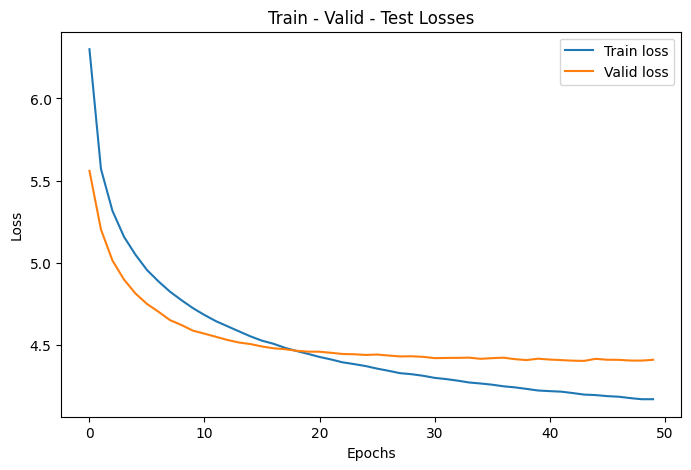

In [107]:
plt.figure(num = 3, figsize=(8, 5)).patch.set_facecolor('white')
plt.title('Train - Valid - Test Losses')
plt.ylabel('Loss')
plt.xlabel('Epochs')
plt.plot(sampled_epoch_ed_vd_wd_1, train_losses_ed_vd_wd_1, label='Train loss')
plt.plot(sampled_epoch_ed_vd_wd_1, valid_losses_ed_vd_wd_1, label='Valid loss')
plt.legend()
plt.show()

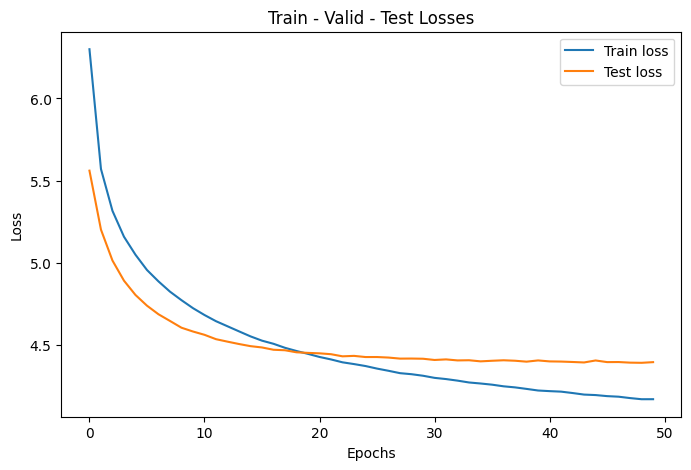

In [108]:
plt.figure(num = 3, figsize=(8, 5)).patch.set_facecolor('white')
plt.title('Train - Valid - Test Losses')
plt.ylabel('Loss')
plt.xlabel('Epochs')
plt.plot(sampled_epoch_ed_vd_wd_1, train_losses_ed_vd_wd_1, label='Train loss')
plt.plot(sampled_epoch_ed_vd_wd_1, test_losses_ed_vd_wd_1, label='Test loss')
plt.legend()
plt.show()

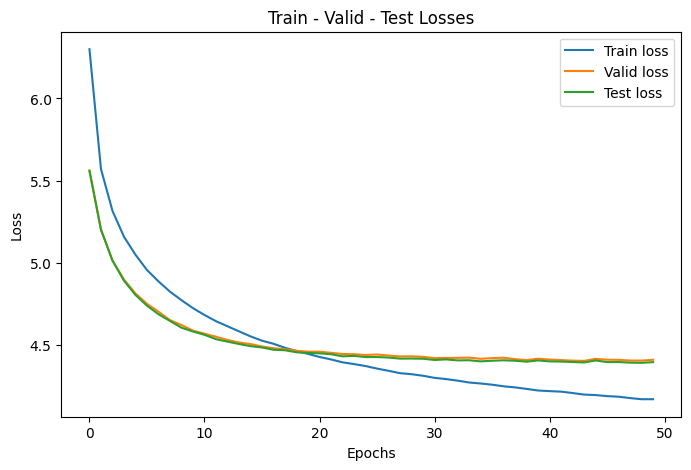

In [109]:
plt.figure(num = 3, figsize=(8, 5)).patch.set_facecolor('white')
plt.title('Train - Valid - Test Losses')
plt.ylabel('Loss')
plt.xlabel('Epochs')
plt.plot(sampled_epoch_ed_vd_wd_1, train_losses_ed_vd_wd_1, label='Train loss')
plt.plot(sampled_epoch_ed_vd_wd_1, valid_losses_ed_vd_wd_1, label='Valid loss')
plt.plot(sampled_epoch_ed_vd_wd_1, test_losses_ed_vd_wd_1, label='Test loss')
plt.legend()
plt.show()

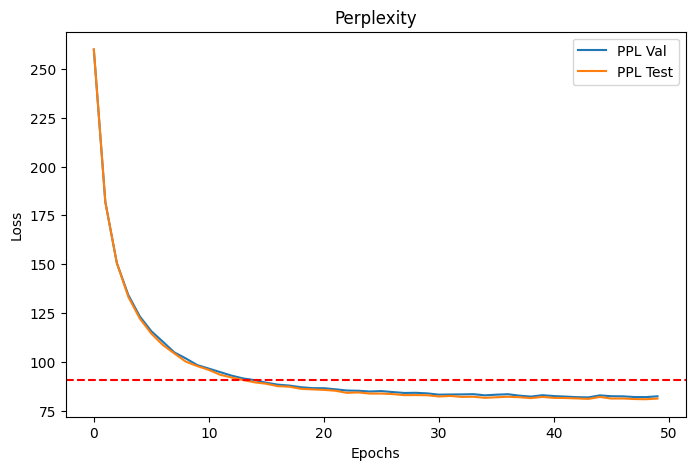

In [110]:
plt.figure(num = 3, figsize=(8, 5)).patch.set_facecolor('white')
plt.title('Perplexity')
plt.ylabel('PPL')
plt.xlabel('Epochs')
plt.plot(sampled_epoch_ed_vd_wd_1, ppl_score_ed_vd_wd_1_val, label='PPL Val')
plt.plot(sampled_epoch_ed_vd_wd_1, ppl_score_ed_vd_wd_1_test, label='PPL Test')
plt.axhline(y=90.7, color='r', linestyle='--')
plt.legend()
plt.savefig('valid_ppl_ed_vd_wd_1.png')
plt.show()

## Sentence generation

In [ ]:
lstm_ed_vd_wd_2l.load_state_dict(torch.load('/content/gdrive/MyDrive/best-val-lstm_ed_vd_wd_2l_1_2.pt'))

<All keys matched successfully>

In [ ]:
print(' '.join(generate_sentence(lstm_ed_vd_wd_2l, 'the', train_dataset.vocab)))

the chartered casualty conversion ramada trend prone statement statement massachusetts massachusetts centuries playing playing playing simply regained lend strange sad congressman helmsley guilty fe guilty


In [ ]:
print(' '.join(generate_sentence(lstm_ed_vd_wd_2l, 'a', train_dataset.vocab)))

a widen developers alleviate primerica gubernatorial deere exodus to to emphasis supports supports argued sides peasant argued argued hatch inches hatch wanting hatch hatch cheating


In [ ]:
print(' '.join(generate_sentence(lstm_ed_vd_wd_2l, 'new york', train_dataset.vocab)))

new york complaints disrupt cbs complaints receive repression third-largest turmoil turmoil then machinists then then doctors doctors about inaccurate photo cost might might cost integrate


In [ ]:
print(' '.join(generate_sentence(lstm_ed_vd_wd_2l, 'he said many of the countries', train_dataset.vocab)))

he said many of the countries taiwan london-based pitch stearns stearns dunes got got defenders insisting freed libya herald herald herald reduce qualified facility facility


## Conclusions
The recurrent part of the LSTM is very sensitive to changes. In fact, using Weight Drop only on the first recurrent layer slightly worsen the performance. This is confirmed by applying it to all the 3 LSTMs where the PPL score is even worse, showing that the input recurrent layer must be non-dropped (results not reported in the report).
The best way to apply Drop Connect is to use the mask on the second (weight_hh_l1) and third recurrent layer (weight_hh_l2).

# Improving LSTM: Embedding Dropout - Variational Dropout - Weight Drop ASGD LSTM

## Non-monotically Average Stochastic Gradient Descent class
Non-monotically Average Stochastic Gradient Descent class for switching from SGD to ASGD during training.

In [111]:
class NT_ASGD():
    """Non-monotonically triggered averaged stochastic gradient descent"""
    def __init__(self, lr, weight_decay, n):
        self.lr = lr
        self.weight_decay = weight_decay
        self.n = n

        self.asgd_triggered = False
        self.losses = []

    def get_optimizer(self, val_loss):
        n = self.n    # the non-monotone interval
        self.losses.append(val_loss)

        # Don't consider trigger condition until n+1
        # losses have been recorded
        if len(self.losses) < n+1:
            trigger = False
        else:
            trigger = self.losses[-n-1] < min(self.losses[-n:])

        # Switch to ASGD if loss hasn't improved for n timesteps
        # This is a one-way switch
        if not self.asgd_triggered and trigger:

            self.asgd_triggered = True

        return self.asgd_triggered


In [114]:
awd_lstm = AWD_LSTM(vocab_size, embedding_dim, hidden_dim, num_layers, dropout_rate, device).to(device)
awd_lstm.apply(init_weights)
optimizer = optim.SGD(awd_lstm.parameters(), lr=lr)
criterion = nn.CrossEntropyLoss(ignore_index = PAD_TOKEN)
num_params = sum(p.numel() for p in awd_lstm.parameters() if p.requires_grad)
print(f'The model has {num_params:,} trainable parameters')

Applying weight drop of 0.2 to weight_hh_l1
Applying weight drop of 0.2 to weight_hh_l2
The model has 7,839,951 trainable parameters


In [115]:
nt_asgd = NT_ASGD(lr, 1.2e-6, 5)
eval_loss = 1000
best_valid_loss = float('inf')

train_losses_lstm_asgd = []
valid_losses_lstm_asgd = []
test_losses_lstm_asgd = []
ppl_score_awd_val = []
ppl_score_awd_test = []
sampled_epoch_asgd = []

for epoch in range(N_EPOCHS+20):
  print('epoch', epoch)
  asgd_triggered = nt_asgd.get_optimizer(eval_loss)
  if asgd_triggered:
      print('switch to ASGD...')
      optimizer = optim.ASGD(awd_lstm.parameters(), lr, t0=0, lambd=0, weight_decay=1.2e-6)
  else:
      print('SGD optimization')
      optimizer = optim.SGD(awd_lstm.parameters(), lr)
  train_loss = train_loop(awd_lstm, train_dataloader, optimizer, criterion, batch_size, clip, device)
  eval_loss = eval_loop(awd_lstm, valid_dataloader, optimizer, criterion, batch_size, device)
  test_loss = test_loop(awd_lstm, test_dataloader, optimizer, criterion, batch_size, device)

  if eval_loss < best_valid_loss:
    best_valid_loss = eval_loss
    torch.save(awd_lstm.state_dict(), '/content/gdrive/MyDrive/best-val-awd_lstm.pt')
  print(f'\n\tTrain Loss: {train_loss:.3f}')
  print(f'\tValid Loss: {eval_loss:.3f}')
  print(f'\tTest Loss: {test_loss:.3f}')
  print(f'\tTrain Perplexity: {math.exp(train_loss):.3f}')
  print(f'\tValid Perplexity: {math.exp(eval_loss):.3f}')
  print(f'\tTest Perplexity: {math.exp(test_loss):.3f}')
  train_losses_lstm_asgd.append(train_loss)
  valid_losses_lstm_asgd.append(eval_loss)
  test_losses_lstm_asgd.append(test_loss)
  sampled_epoch_asgd.append(epoch)
  ppl_score_awd_val.append(math.exp(eval_loss))
  ppl_score_awd_test.append(math.exp(test_loss))



epoch 0
SGD optimization


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/rnn.py:815: UserWarning: RNN module weights are not part of single contiguous chunk of memory. This means they need to be compacted at every call, possibly greatly increasing memory usage. To compact weights again call flatten_parameters(). (Triggered internally at ../aten/src/ATen/native/cudnn/RNN.cpp:982.)
  result = _VF.lstm(input, batch_sizes, hx, self._flat_weights, self.bias,



	Train Loss: 6.333
	Valid Loss: 5.607
	Test Loss: 5.602
	Train Perplexity: 562.972
	Valid Perplexity: 272.392
	Test Perplexity: 270.952
epoch 1
SGD optimization

	Train Loss: 5.606
	Valid Loss: 5.227
	Test Loss: 5.224
	Train Perplexity: 272.169
	Valid Perplexity: 186.214
	Test Perplexity: 185.697
epoch 2
SGD optimization

	Train Loss: 5.356
	Valid Loss: 5.054
	Test Loss: 5.054
	Train Perplexity: 211.850
	Valid Perplexity: 156.616
	Test Perplexity: 156.663
epoch 3
SGD optimization

	Train Loss: 5.202
	Valid Loss: 4.936
	Test Loss: 4.927
	Train Perplexity: 181.705
	Valid Perplexity: 139.166
	Test Perplexity: 137.959
epoch 4
SGD optimization

	Train Loss: 5.090
	Valid Loss: 4.857
	Test Loss: 4.852
	Train Perplexity: 162.406
	Valid Perplexity: 128.680
	Test Perplexity: 128.032
epoch 5
SGD optimization

	Train Loss: 5.001
	Valid Loss: 4.784
	Test Loss: 4.774
	Train Perplexity: 148.541
	Valid Perplexity: 119.564
	Test Perplexity: 118.425
epoch 6
SGD optimization

	Train Loss: 4.926
	Valid L

## Plots

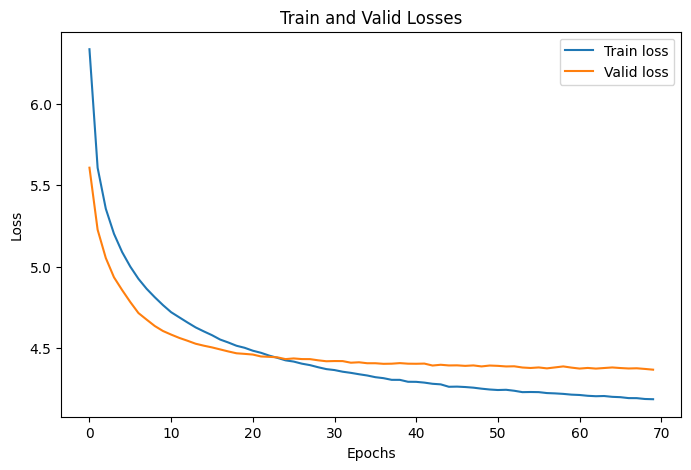

In [116]:
plt.figure(num = 3, figsize=(8, 5)).patch.set_facecolor('white')
plt.title('Train and Valid Losses')
plt.ylabel('Loss')
plt.xlabel('Epochs')
plt.plot(sampled_epoch_asgd, train_losses_lstm_asgd, label='Train loss')
plt.plot(sampled_epoch_asgd, valid_losses_lstm_asgd, label='Valid loss')
plt.legend()
plt.show()

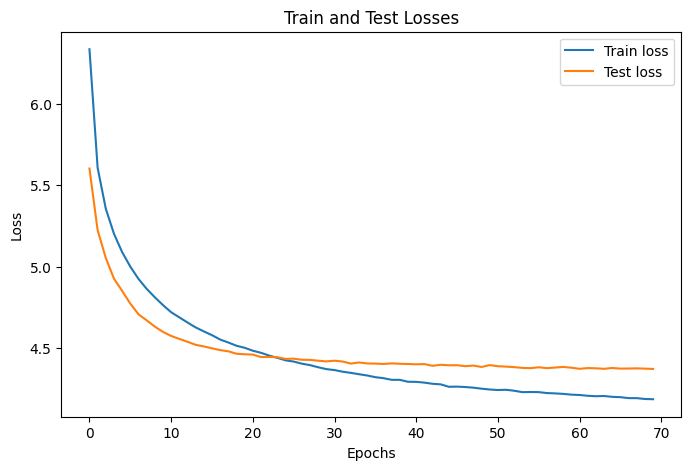

In [117]:
plt.figure(num = 3, figsize=(8, 5)).patch.set_facecolor('white')
plt.title('Train and Test Losses')
plt.ylabel('Loss')
plt.xlabel('Epochs')
plt.plot(sampled_epoch_asgd, train_losses_lstm_asgd, label='Train loss')
plt.plot(sampled_epoch_asgd, test_losses_lstm_asgd, label='Test loss')
plt.legend()
plt.show()

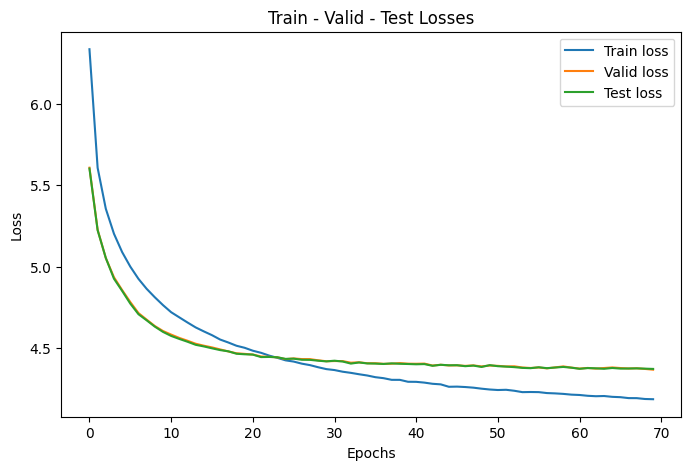

In [118]:
plt.figure(num = 3, figsize=(8, 5)).patch.set_facecolor('white')
plt.title('Train - Valid - Test Losses')
plt.ylabel('Loss')
plt.xlabel('Epochs')
plt.plot(sampled_epoch_asgd, train_losses_lstm_asgd, label='Train loss')
plt.plot(sampled_epoch_asgd, valid_losses_lstm_asgd, label='Valid loss')
plt.plot(sampled_epoch_asgd, test_losses_lstm_asgd, label='Test loss')
plt.legend()
plt.show()

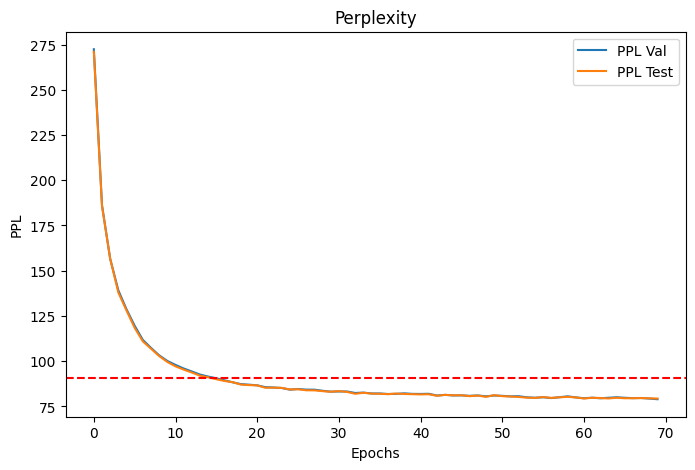

In [121]:
plt.figure(num = 3, figsize=(8, 5)).patch.set_facecolor('white')
plt.title('Perplexity')
plt.ylabel('PPL')
plt.xlabel('Epochs')
plt.plot(sampled_epoch_asgd, ppl_score_awd_val, label='PPL Val')
plt.plot(sampled_epoch_asgd, ppl_score_awd_test, label='PPL Test')
plt.axhline(y=90.7, color='r', linestyle='--')
plt.legend()
plt.savefig('valid_ppl_ed_vd_wd_1.png')
plt.show()

## Sentence generation

In [ ]:
awd_lstm.load_state_dict(torch.load('/content/gdrive/MyDrive/best-val-awd_lstm.pt'))

<All keys matched successfully>

In [ ]:
print(' '.join(generate_sentence(awd_lstm, 'the', train_dataset.vocab)))

the company said it will sell its N N stake to the company 's N million common shares eos


In [ ]:
print(' '.join(generate_sentence(awd_lstm, 'a', train_dataset.vocab)))

a spokesman for the company 's board said the company 's decision to meet the plan is expected eos


In [ ]:
print(' '.join(generate_sentence(awd_lstm, 'new york', train_dataset.vocab)))

new york stock exchanges were suspended in a trading session in the past N days eos


In [ ]:
print(' '.join(generate_sentence(awd_lstm, 'he said many of the countries', train_dataset.vocab)))

he said many of the countries are still being forced for the u.s. and europe eos


## Comparison plots
In the image below shows the best perplexity of the main models

In [122]:
min_losses = [min(test_losses_lstm), min(test_losses_ed), min(test_losses_ed_vd), min(test_losses_ed_vd_wd), min(test_losses_lstm_asgd)]
labels = ['lstm', 'lstm_ed', 'lstm_ed_vd', 'lstm_ed_vd_wd', 'lstm_asgd']

In [123]:
perplexities = [math.exp(loss) for loss in min_losses]

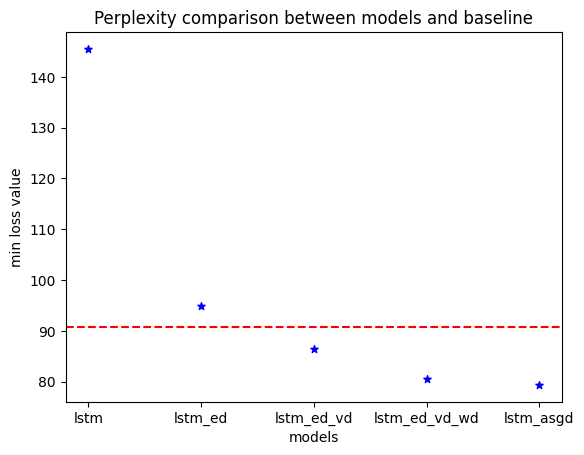

In [124]:
plt.scatter(labels, perplexities, color= "blue", marker= "*", s=30)

plt.xlabel('models')
# frequency label
plt.ylabel('min loss value')
# plot title
plt.title('Perplexity comparison between models and baseline')

plt.axhline(y=90.7, color='r', linestyle='--')
# function to show the plot
plt.show()

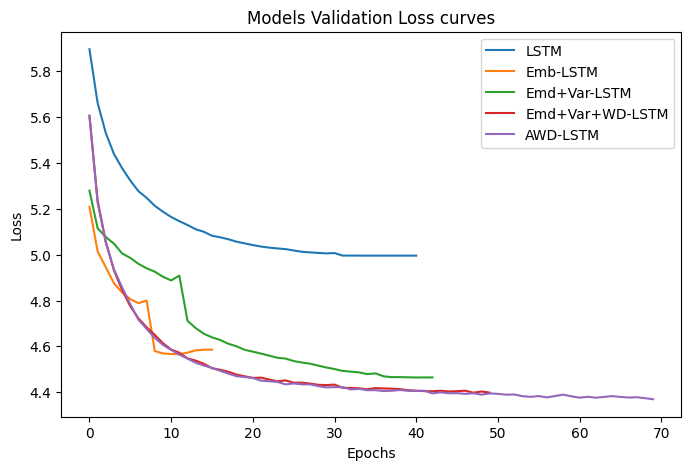

In [125]:
plt.figure(num = 3, figsize=(8, 5)).patch.set_facecolor('white')
plt.title('Models'' Validation Loss curves')
plt.ylabel('Loss')
plt.xlabel('Epochs')
plt.plot(sampled_epoch_lstm, valid_losses_lstm, label='LSTM')
plt.plot(sampled_epoch_ed, valid_losses_ed, label='Emb-LSTM')
plt.plot(sampled_epoch_ed_vd, valid_losses_ed_vd, label='Emd+Var-LSTM')
plt.plot(sampled_epoch_ed_vd_wd, valid_losses_ed_vd_wd, label='Emd+Var+WD-LSTM')
plt.plot(sampled_epoch_asgd, valid_losses_lstm_asgd, label='AWD-LSTM')

plt.plot()
plt.legend()
plt.savefig('valid_loss_curves.png')
plt.show()


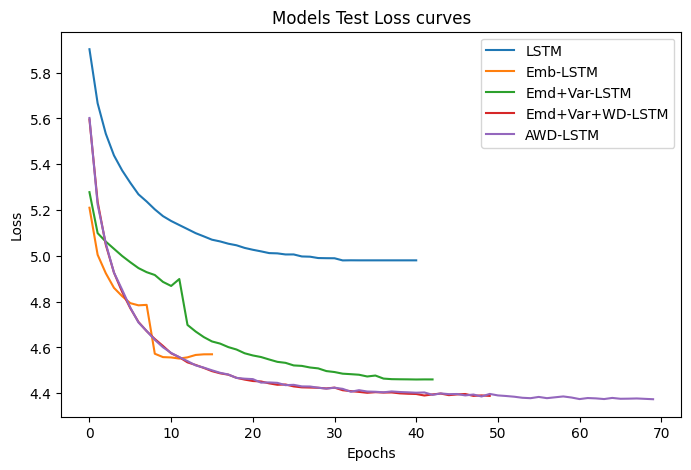

In [126]:
plt.figure(num = 3, figsize=(8, 5)).patch.set_facecolor('white')
plt.title('Models'' Test Loss curves')
plt.ylabel('Loss')
plt.xlabel('Epochs')
plt.plot(sampled_epoch_lstm, test_losses_lstm, label='LSTM')
plt.plot(sampled_epoch_ed, test_losses_ed, label='Emb-LSTM')
plt.plot(sampled_epoch_ed_vd, test_losses_ed_vd, label='Emd+Var-LSTM')
plt.plot(sampled_epoch_ed_vd_wd, test_losses_ed_vd_wd, label='Emd+Var+WD-LSTM')
plt.plot(sampled_epoch_asgd, test_losses_lstm_asgd, label='AWD-LSTM')

plt.plot()
plt.legend()
plt.savefig('test_loss_curves.png')
plt.show()


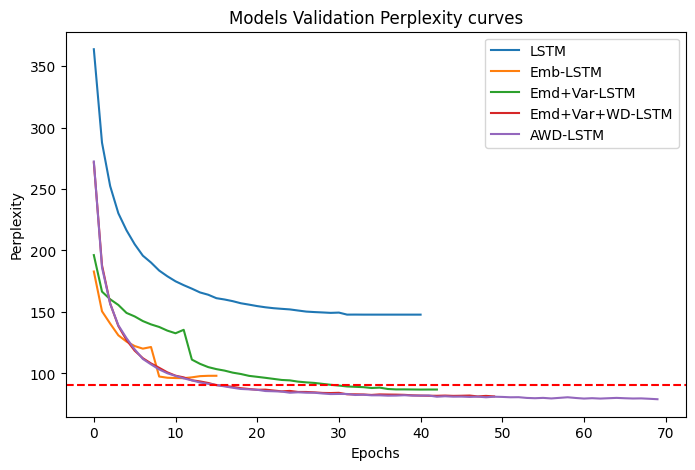

In [127]:
plt.figure(num = 3, figsize=(8, 5)).patch.set_facecolor('white')
plt.title('Models'' Validation Perplexity curves')
plt.ylabel('Perplexity')
plt.xlabel('Epochs')
plt.plot(sampled_epoch_lstm, ppl_score_lstm_val, label='LSTM')
plt.plot(sampled_epoch_ed, ppl_score_ed_val, label='Emb-LSTM')
plt.plot(sampled_epoch_ed_vd, ppl_score_ed_vd_val, label='Emd+Var-LSTM')
plt.plot(sampled_epoch_ed_vd_wd, ppl_score_ed_vd_wd_val, label='Emd+Var+WD-LSTM')
plt.plot(sampled_epoch_asgd, ppl_score_awd_val, label='AWD-LSTM')

plt.axhline(y=90.7, color='r', linestyle='--')

plt.plot()
plt.legend()
plt.savefig('valid_perplexity_curves.png')
plt.show()


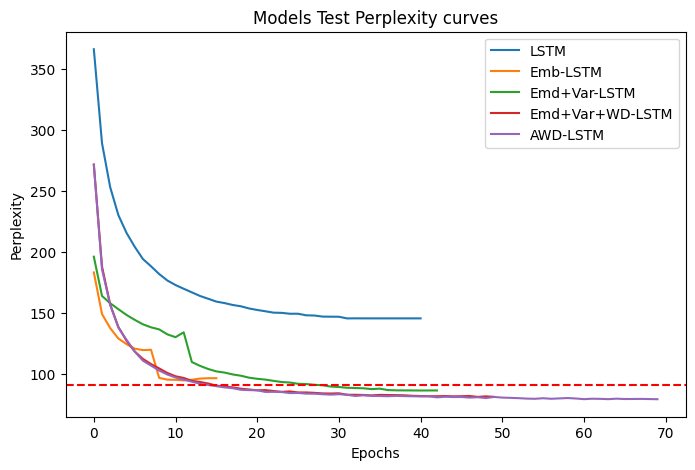

In [128]:
plt.figure(num = 3, figsize=(8, 5)).patch.set_facecolor('white')
plt.title('Models'' Test Perplexity curves')
plt.ylabel('Perplexity')
plt.xlabel('Epochs')
plt.plot(sampled_epoch_lstm, ppl_score_lstm_test, label='LSTM')
plt.plot(sampled_epoch_ed, ppl_score_ed_test, label='Emb-LSTM')
plt.plot(sampled_epoch_ed_vd, ppl_score_ed_vd_test, label='Emd+Var-LSTM')
plt.plot(sampled_epoch_ed_vd_wd, ppl_score_ed_vd_wd_test, label='Emd+Var+WD-LSTM')
plt.plot(sampled_epoch_asgd, ppl_score_awd_test, label='AWD-LSTM')

plt.axhline(y=90.7, color='r', linestyle='--')

plt.plot()
plt.legend()
plt.savefig('valid_perplexity_curves.png')
plt.show()

## Final Conclusions
The last model uses Embedding Dropout, Variational Dropout and Weight Dropout (Drop Connect) along with ASGD. Since we want to reach the best PPL possible we set the number of epochs to 70 instead of 50. The three regularization techniques help to achieve a good PPL, indeed the LSTM scores 81.7 PPL on the dev set and 81.2 on the test set. The ASGD seems to be useful, improving the PPL score on the two sets of around 1.5 points. It is curious to notice that the 3 curves (train-valid-test loss functions) are less far from each other and has got a more regular pace.
In conclusion we can say that the best way to improve the perfomance is to rightly regularize the model in all its layers. Since each of them does a specific sub-task (i.e. the embedding layer is responsible for learning the best word representation etc..) this might be the reason why we need a different dropout technique for each of them. Moreover, the recurrent part has revealed as the more sensitive to changes, indeed using dropout on the input recurrent layer partially destroys the ability of the network to retain the relationships.

